# House prices regression pt.1

Project objectives:
1) Rank decently on the leaderboards of the Kaggle competition that uses the [house prices dataset](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data)
2) Have model deployed as a model-as-a-service

Notebook objectives:
1) Investigate the properties of the data
    - Numerical
        - Continuous
            - Skewed
            - Less skewed
        - True discrete (not ordinal categoricals)
    - Categorical
        - Ordinal
        - Nominal
2) Narrow down on feature engineering techniques to try
    - What new features to create, how they impact the target
    - How to represent features for input into model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from sklearn.model_selection import train_test_split

Check for the basic structure of our data to get a feel for things.

In [2]:
data = pd.read_csv("../data/train.csv", index_col=False)

There are a good number of columns, so simple descriptive methods will not be useful for getting a quick understanding of our data. Instead, we will do some aggregations

In [3]:
data.dtypes.value_counts()

object     43
int64      35
float64     3
Name: count, dtype: int64

In [4]:
data.duplicated().any()

False

In [5]:
na_vars = data.columns[data.isnull().sum(axis=0) > 0].tolist()

In [6]:
data[na_vars].isnull().mean().sort_values(ascending=False)

PoolQC          0.995205
MiscFeature     0.963014
Alley           0.937671
Fence           0.807534
MasVnrType      0.597260
FireplaceQu     0.472603
LotFrontage     0.177397
GarageType      0.055479
GarageYrBlt     0.055479
GarageFinish    0.055479
GarageQual      0.055479
GarageCond      0.055479
BsmtFinType2    0.026027
BsmtExposure    0.026027
BsmtFinType1    0.025342
BsmtCond        0.025342
BsmtQual        0.025342
MasVnrArea      0.005479
Electrical      0.000685
dtype: float64

In [7]:
data.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

Simple survey reveals to us:
- No duplicates
- Have missing values
- Not many continuous features

## Data viz checklist
1) Target: Distribution
2) Data cleaning:
    - Missing value rates: Determine the type of imputation techniques to try
        - Barplots
    - Impact of missing values on target: Determine the type of imputation techniques to try
        - Bivariate boxplots
    - Convert unordered discretes to categorical
    - Convert ordinal categoricals to numerical discrete
3) Numerical:
    - Temporal: Understand how to break down datetime
        - Bivariate boxplots
    - Discrete: Understand which features are important, determine threshold for generalising discretes
        - Univariate barplots    
    - Continuous: Check if transforms needed, inspect outlier behaviour, check for multicolinearity
        - Histograms
        - Scattermatrix, Correlation matrix (inclusive of discretes)
        - Bivariate barplots for skewed: Understand how skewed features affect target
4) Categorical: 
    - Cardinality: Determine the threshold for generalising categories
        - Barplots (countplot)
    - Rare labels: Determine the threshold for generalising categories
    - Understand which features are important
        - Bivariate boxplots

In [8]:
train, test = train_test_split(data, test_size=0.1, random_state=0)

In [9]:
cat_vars = [var for var in train.columns if train[var].dtype == 'object']
cat_vars += ['MSSubClass']
len(cat_vars)

44

In [10]:
num_vars = [
    var for var in train.columns if var not in cat_vars and var != 'SalePrice' and var!= 'Id'
]
len(num_vars)

35

In [11]:
year_vars = [var for var in num_vars if 'Yr' in var or 'Year' in var]

discrete_vars = [var for var in num_vars if (train[var].nunique() < 20) 
                 and var not in year_vars]

cont_vars = [var for var in num_vars if var not in discrete_vars and var not in year_vars]

## Target

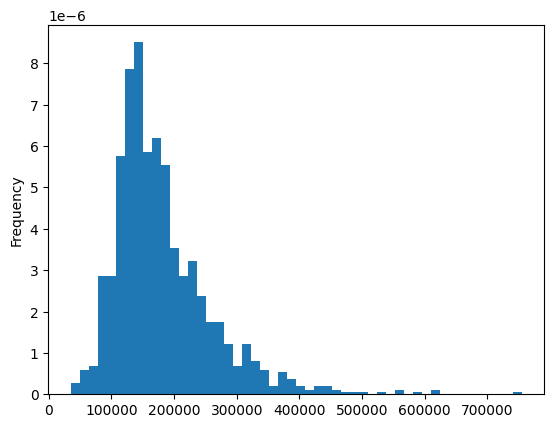

In [12]:
train['SalePrice'].plot.hist(bins=50, density=True);

Taking log of the target might be a good idea. Can help improve on distribution to satisfy assumptions of some models.

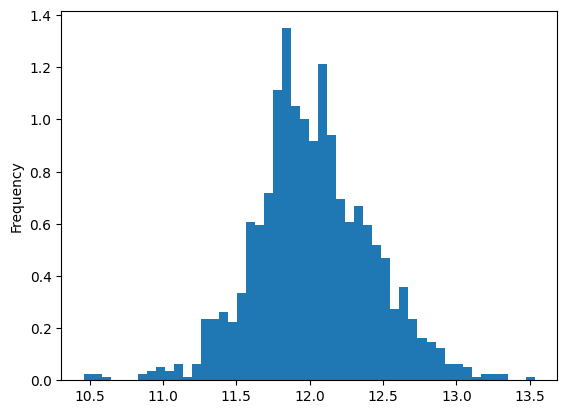

In [13]:
train['SalePrice'].apply(np.log1p).plot.hist(bins=50, density=True);

Indeed, distribution is improved.

## Numericals

### Temporal

In [14]:
for var in year_vars:
    print(var)
    print(train[var].sort_values(ascending=False).unique())
    print()

YearBuilt
[2010 2009 2008 2007 2006 2005 2004 2003 2002 2001 2000 1999 1998 1997
 1996 1995 1994 1993 1992 1991 1990 1989 1988 1987 1986 1985 1984 1983
 1982 1981 1980 1979 1978 1977 1976 1975 1974 1973 1972 1971 1970 1969
 1968 1967 1966 1965 1964 1963 1962 1961 1960 1959 1958 1957 1956 1955
 1954 1953 1952 1951 1950 1949 1948 1947 1946 1945 1942 1941 1940 1939
 1938 1937 1936 1935 1934 1932 1931 1930 1929 1928 1927 1926 1925 1924
 1923 1922 1921 1920 1919 1918 1917 1916 1915 1914 1912 1911 1910 1908
 1906 1905 1904 1900 1898 1893 1892 1890 1885 1880 1875 1872]

YearRemodAdd
[2010 2009 2008 2007 2006 2005 2004 2003 2002 2001 2000 1999 1998 1997
 1996 1995 1994 1993 1992 1991 1990 1989 1988 1987 1986 1985 1984 1983
 1982 1981 1980 1979 1978 1977 1976 1975 1974 1973 1972 1971 1970 1969
 1968 1967 1966 1965 1964 1963 1962 1961 1960 1959 1958 1957 1956 1955
 1954 1953 1952 1951 1950]

GarageYrBlt
[2010. 2009. 2008. 2007. 2006. 2005. 2004. 2003. 2002. 2001. 2000. 1999.
 1998. 1997. 1996. 1

In [15]:
train[year_vars].dtypes

YearBuilt         int64
YearRemodAdd      int64
GarageYrBlt     float64
YrSold            int64
dtype: object

In [16]:
def plot_temporal(var, log_predictor=False, log_target=False):
    new_var = 'YrSold - ' + var
    df = train.copy()
    df[new_var] = df['YrSold'] - df[var]
    if log_predictor:
        df[new_var] = df[new_var].apply(np.log1p)
    if log_target:
        df['SalePrice'] = df['SalePrice'].apply(np.log1p)
    df.plot(x=new_var, y='SalePrice', kind='scatter');

We could create new features that capture the interaction datetime interactions with YrSold

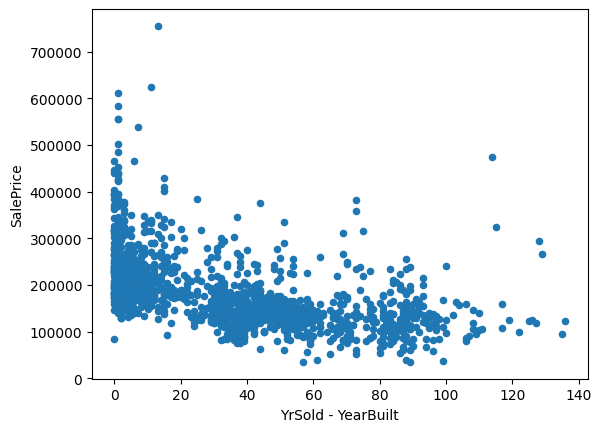

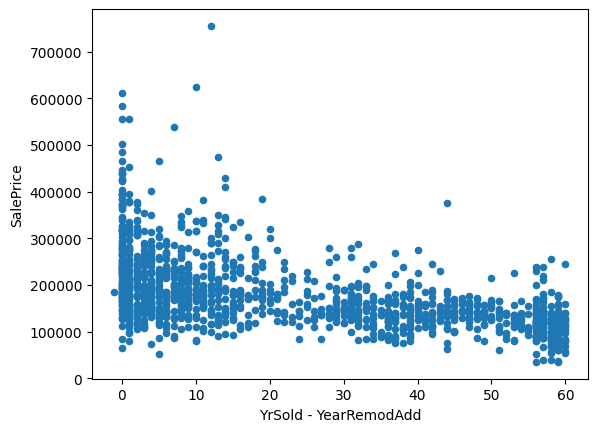

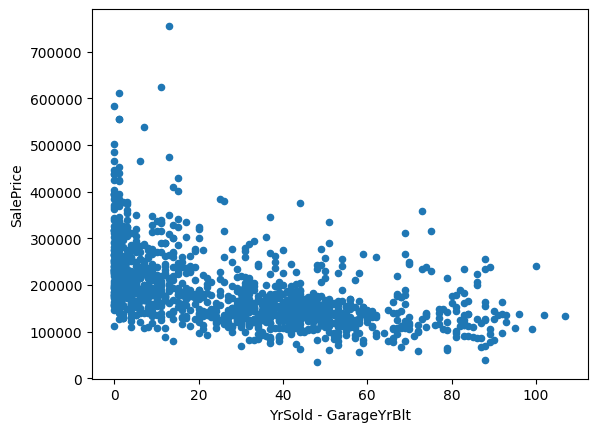

In [17]:
for temporal in year_vars:
    if temporal != 'YrSold':
        plot_temporal(temporal)

In [18]:
tmp = train.copy()
for var in year_vars:
    tmp[var] = tmp['YrSold'] - tmp[var]

In [19]:
tmp[year_vars[:-1]+['SalePrice']].corr()

YearBuilt  YearRemodAdd  GarageYrBlt  SalePrice
YearBuilt      1.000000      0.600242     0.827147  -0.525498
YearRemodAdd   0.600242      1.000000     0.648556  -0.519795
GarageYrBlt    0.827147      0.648556     1.000000  -0.490591
SalePrice     -0.525498     -0.519795    -0.490591   1.000000

We see that sale price generally has an inverse relationship with the age of the house. It is possible to improve linear dependence that each variable has with SalePrice by taking log

In [20]:
for var in year_vars:
    tmp[var] = tmp[var].apply(np.log1p)

In [21]:
tmp[year_vars[:-1]+['SalePrice']].corr()

YearBuilt  YearRemodAdd  GarageYrBlt  SalePrice
YearBuilt      1.000000      0.786541     0.943876  -0.578062
YearRemodAdd   0.786541      1.000000     0.811895  -0.527253
GarageYrBlt    0.943876      0.811895     1.000000  -0.543319
SalePrice     -0.578062     -0.527253    -0.543319   1.000000

In [22]:
tmp['SalePrice'] = tmp['SalePrice'].apply(np.log1p)

In [23]:
tmp[year_vars[:-1]+['SalePrice']].corr()

YearBuilt  YearRemodAdd  GarageYrBlt  SalePrice
YearBuilt      1.000000      0.786541     0.943876  -0.604915
YearRemodAdd   0.786541      1.000000     0.811895  -0.546013
GarageYrBlt    0.943876      0.811895     1.000000  -0.569874
SalePrice     -0.604915     -0.546013    -0.569874   1.000000

We see that taking log on both predictor and target improves correlation between predictors and target. However, it also induces high colinearity between the predictors.

### Discrete

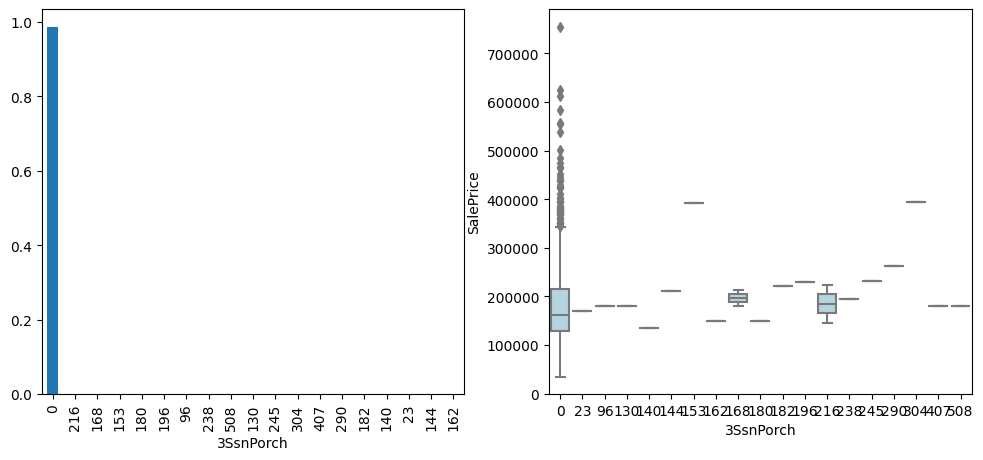

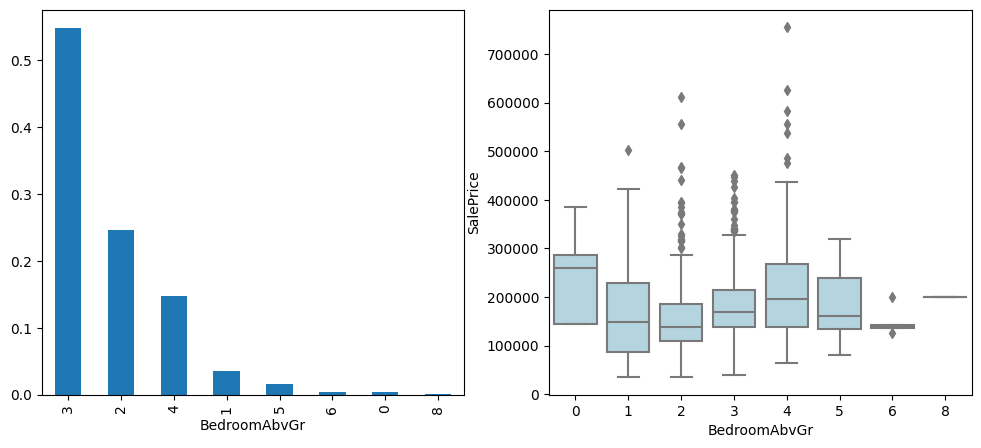

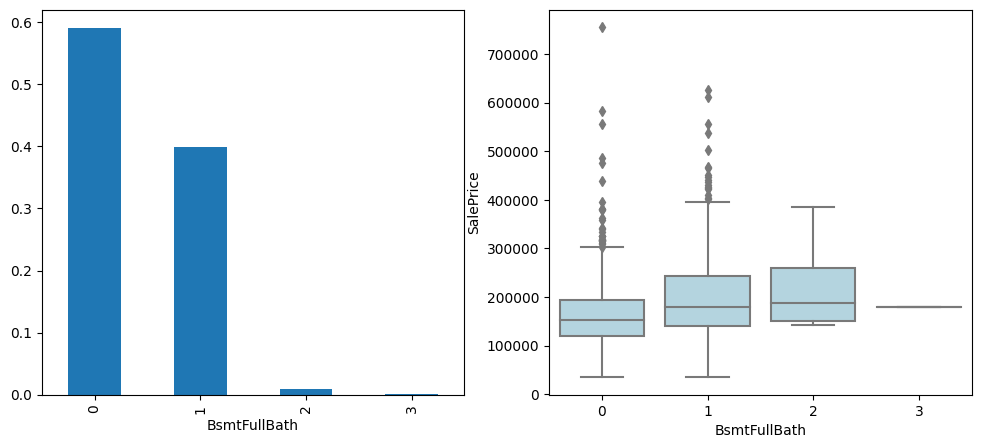

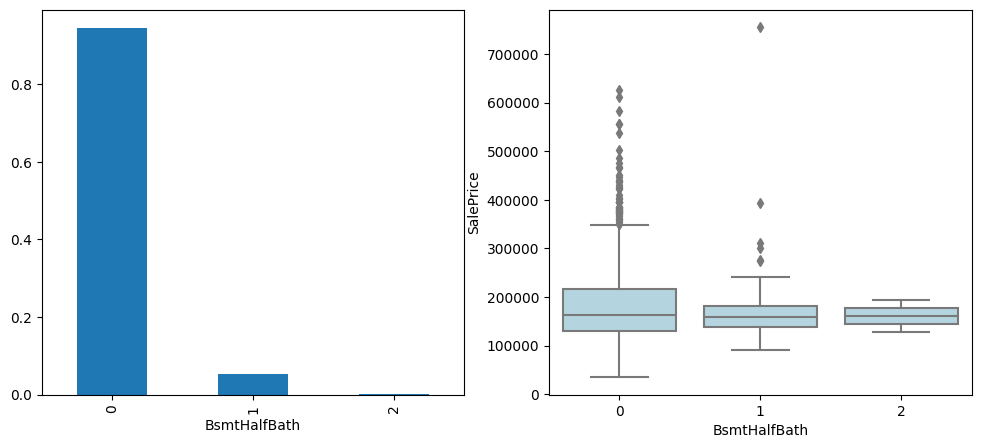

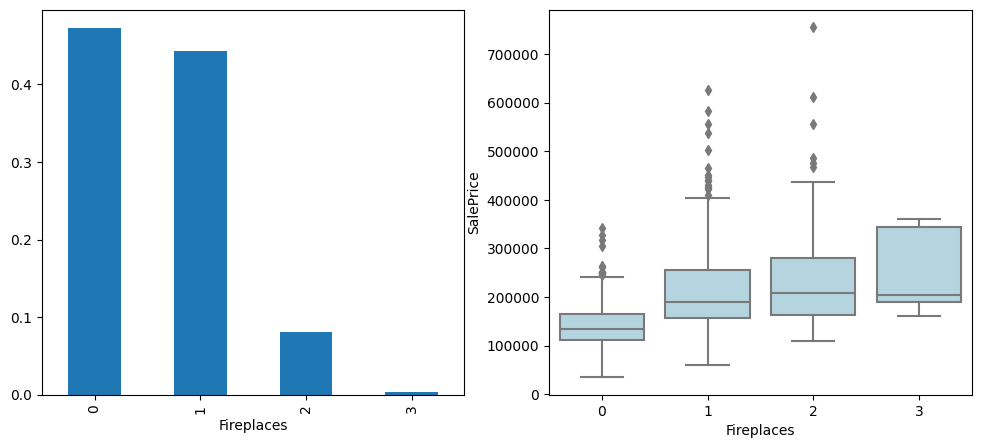

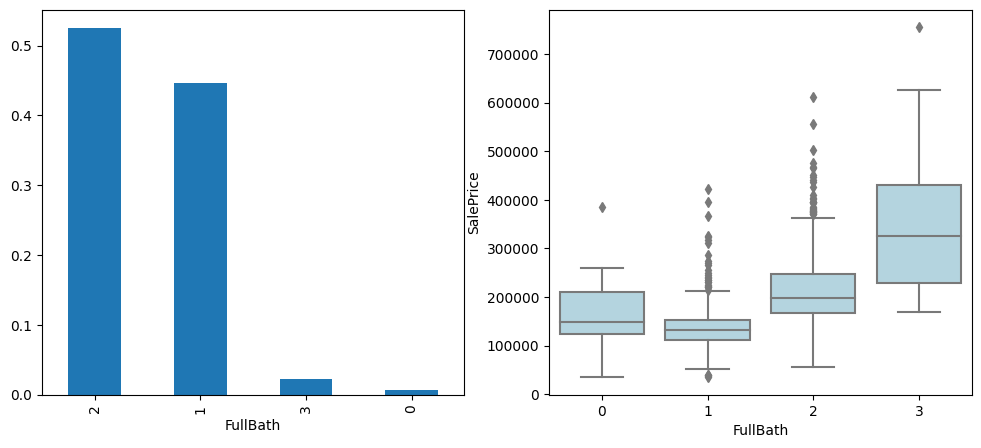

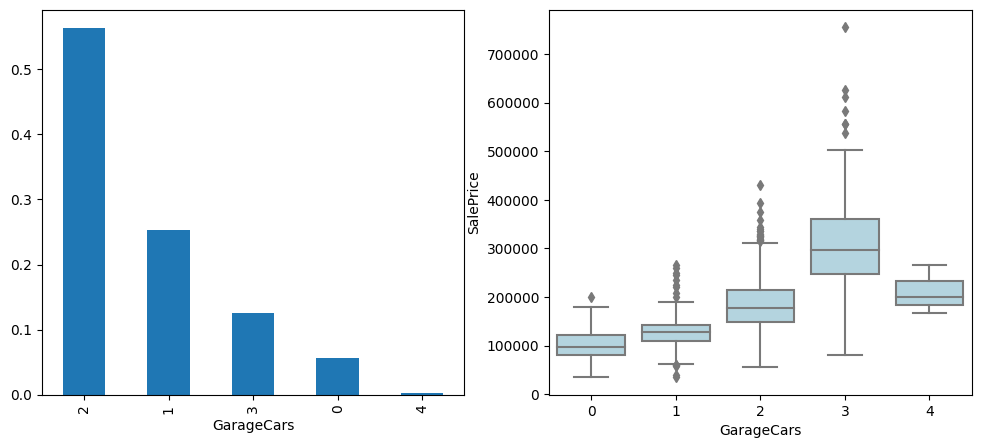

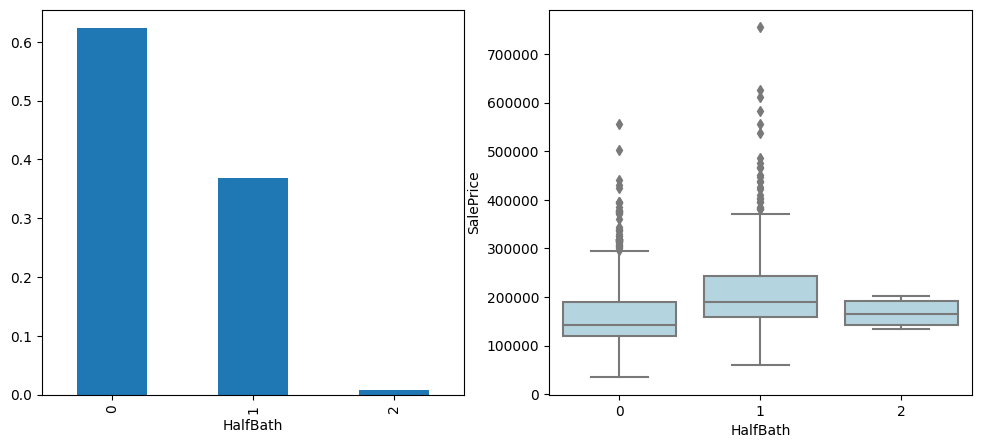

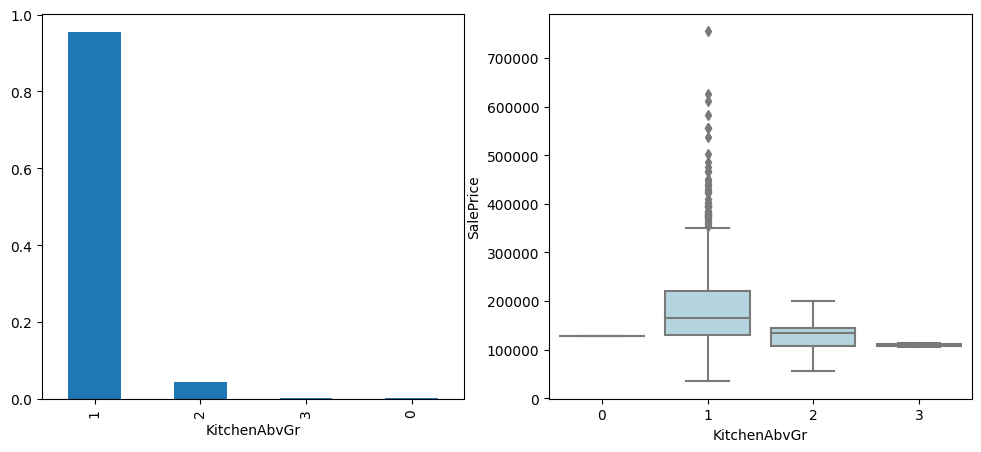

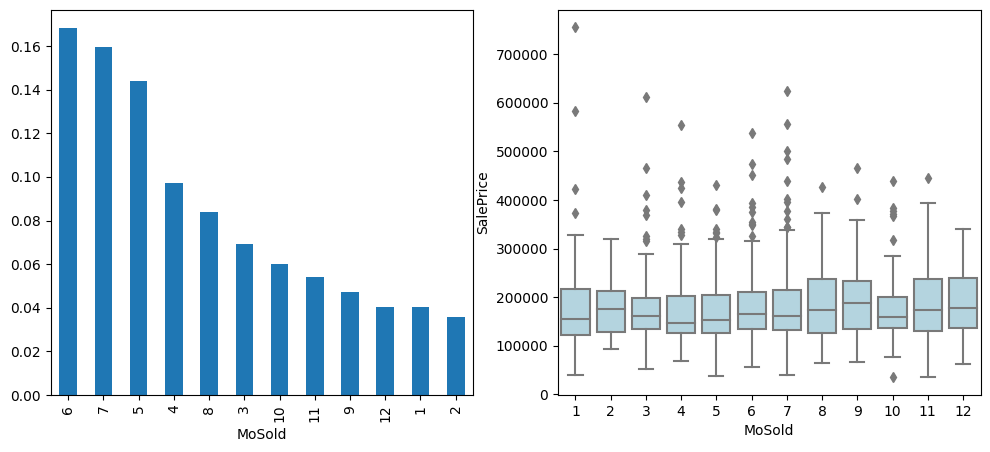

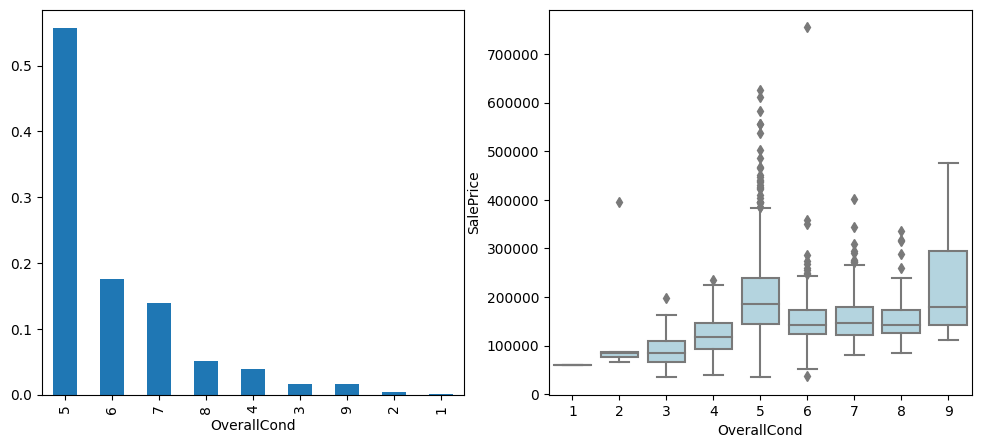

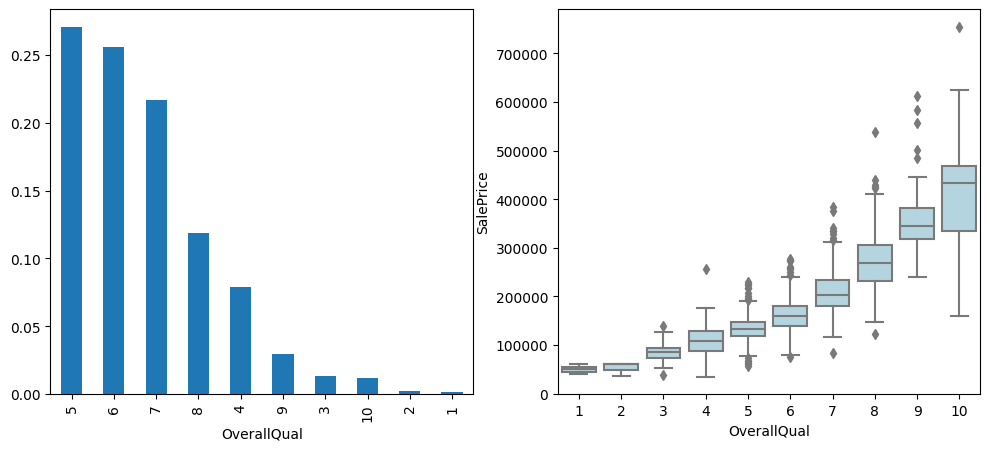

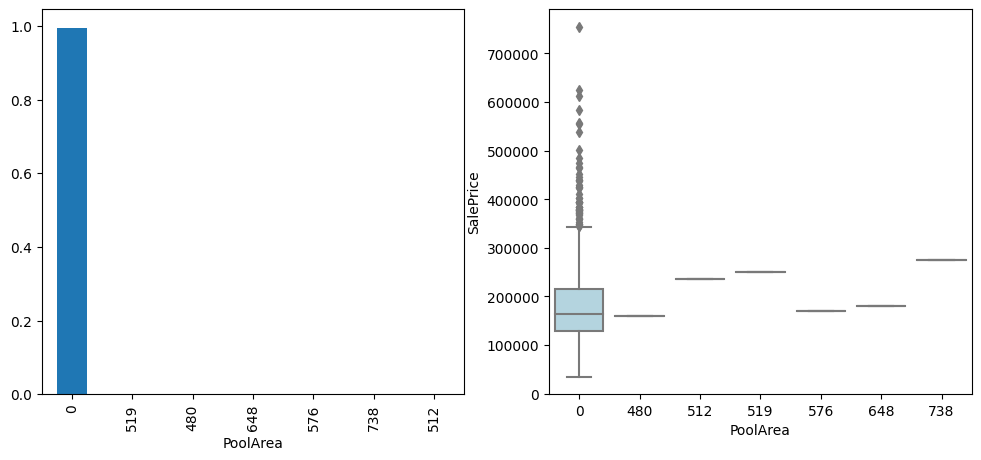

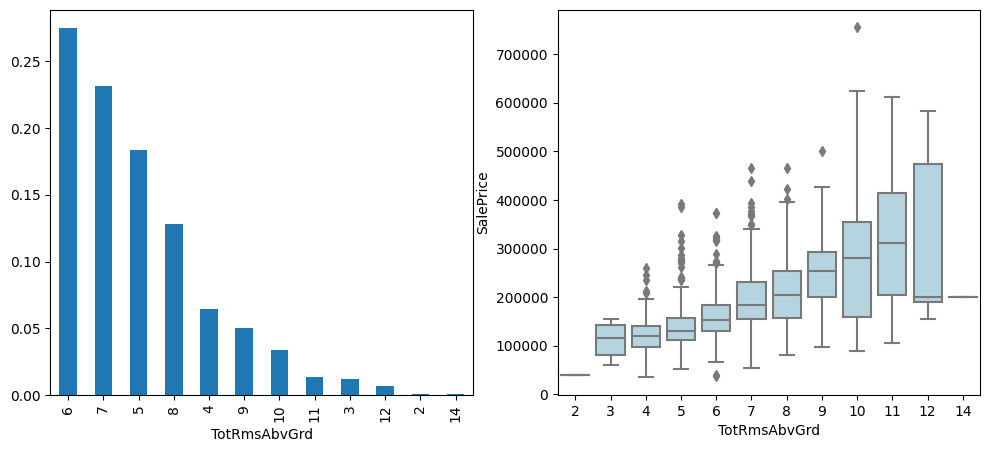

In [24]:
for var in sorted(discrete_vars):
    fig, ax = plt.subplots(figsize=(12, 5), nrows=1, ncols=2)
    train[var].value_counts(normalize=True).plot(kind='bar', ax=ax[0])
    sns.boxplot(data=train, x=var, y='SalePrice', color='lightblue')
    plt.show()

MoSold refers to the month a house was sold. This isn't a numerical so we need to fix that.

In [25]:
discrete_vars.remove('MoSold')
cat_vars.append('MoSold')

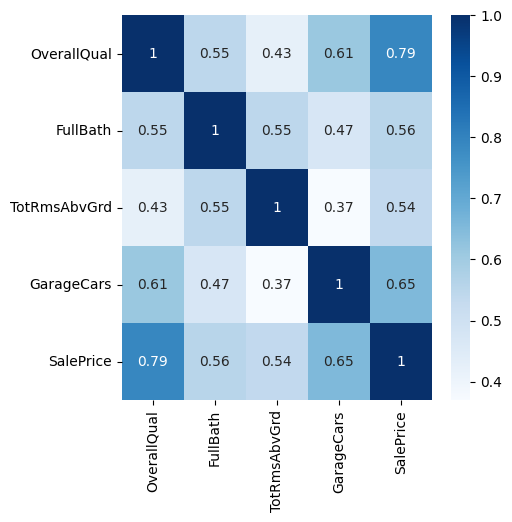

In [26]:
fig, ax = plt.subplots(figsize=(5, 5))
corr = train[discrete_vars+['SalePrice']].corr()
good_correl_idx = np.where(abs(corr['SalePrice']) > 0.5)
good_corr = corr.iloc[good_correl_idx[0], good_correl_idx[0]]
# mask = np.triu(np.ones_like(good_corr, dtype=bool))
cmap = sns.color_palette('Blues', as_cmap=True)
sns.heatmap(good_corr, cmap=cmap, annot=True);

Filtering for features with decent correlation with the target gives us an idea of what variables we may want to use to create new features.

Number of full bathrooms -> Total number of bathrooms?

In [27]:
tmp = train.copy()
tmp['TotBathrooms'] = tmp['BsmtFullBath'] + tmp['BsmtHalfBath']*0.5 + tmp['FullBath'] + tmp['HalfBath']*0.5
tmp['TotRms'] = tmp['TotBathrooms'] + tmp['TotRmsAbvGrd']

tmp[['TotBathrooms', 'TotRms', 'SalePrice']].corr()

TotBathrooms    TotRms  SalePrice
TotBathrooms      1.000000  0.725956   0.633477
TotRms            0.725956  1.000000   0.650359
SalePrice         0.633477  0.650359   1.000000

New features show good signs of correlation with the target

In [28]:
tmp = train.copy()
corr = tmp[discrete_vars+['SalePrice']].corr()
corr['SalePrice'].sort_values(ascending=False)

SalePrice       1.000000
OverallQual     0.790378
GarageCars      0.654430
FullBath        0.556104
TotRmsAbvGrd    0.535134
Fireplaces      0.469393
HalfBath        0.282158
BsmtFullBath    0.239133
BedroomAbvGr    0.160421
3SsnPorch       0.049223
PoolArea        0.028494
BsmtHalfBath   -0.014526
OverallCond    -0.069727
KitchenAbvGr   -0.139296
Name: SalePrice, dtype: float64

In [29]:
tmp = train.copy()
tmp[discrete_vars] = tmp[discrete_vars].apply(np.log1p)
corr = tmp[discrete_vars+['SalePrice']].corr()
corr['SalePrice'].sort_values(ascending=False)

SalePrice       1.000000
OverallQual     0.746950
GarageCars      0.588652
FullBath        0.532226
TotRmsAbvGrd    0.522107
Fireplaces      0.484616
HalfBath        0.289033
BsmtFullBath    0.241707
BedroomAbvGr    0.140277
3SsnPorch       0.049699
PoolArea        0.026856
BsmtHalfBath   -0.014124
OverallCond    -0.045123
KitchenAbvGr   -0.135929
Name: SalePrice, dtype: float64

Taking log on discretes don't seem to improve their correlation with the target

### Continuous

In [30]:
train[cont_vars].head()

LotFrontage  LotArea  MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  \
930          73.0     8925         0.0          16           0       1450   
656          72.0    10007        54.0         806           0        247   
45           61.0     7658       412.0         456           0       1296   
1348          NaN    16196         0.0        1443           0         39   
55          100.0    10175       272.0         490           0        935   

      TotalBsmtSF  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  GarageArea  \
930          1466      1466         0             0       1466         610   
656          1053      1053         0             0       1053         312   
45           1752      1752         0             0       1752         576   
1348         1482      1494         0             0       1494         514   
55           1425      1425         0             0       1425         576   

      WoodDeckSF  OpenPorchSF  EnclosedPorch  ScreenPorch  MiscVal  
930          100           18              0            0        0  
656            0            0              0            0        0  
45           196           82              0            0        0  
1348         402           25              0            0        0  
55             0            0              0            0        0

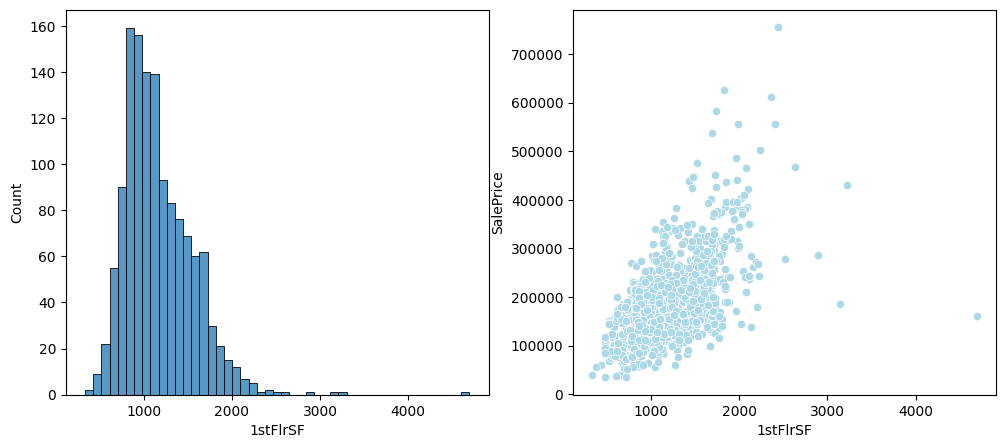

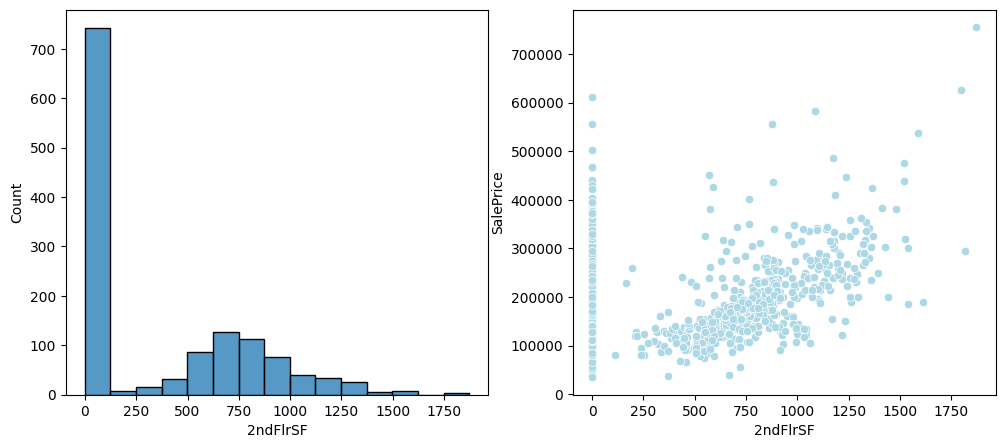

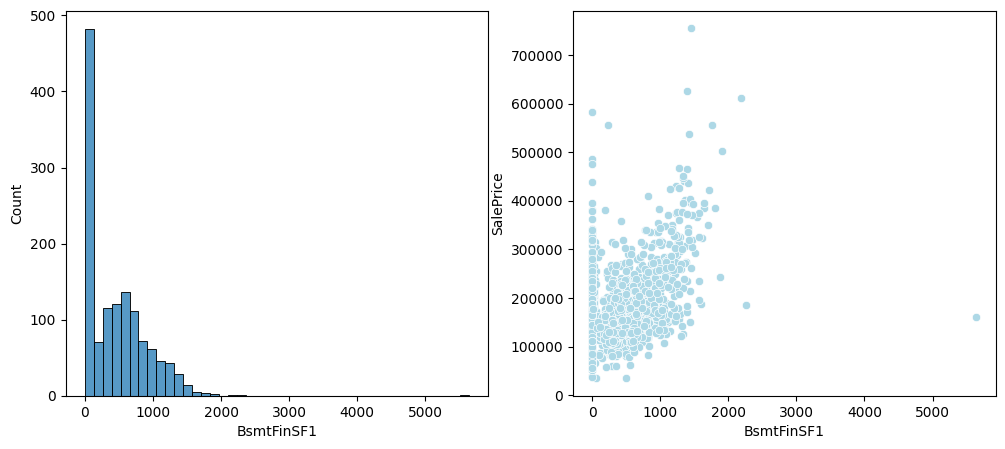

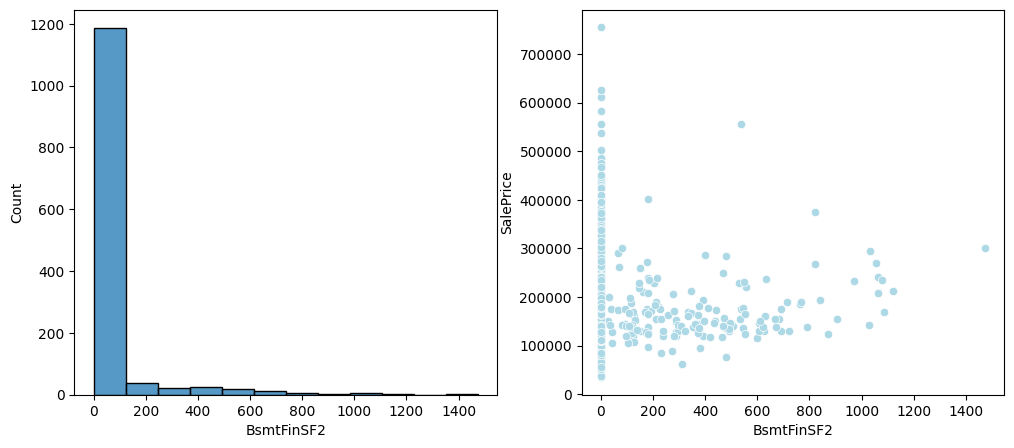

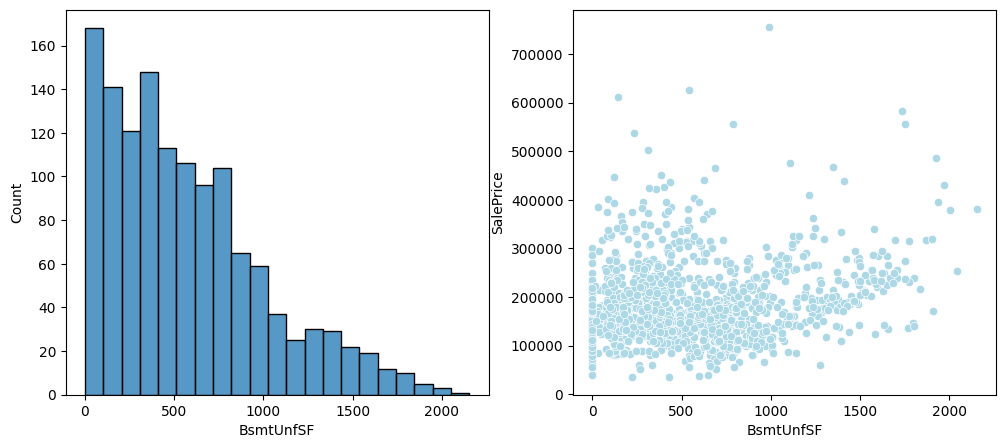

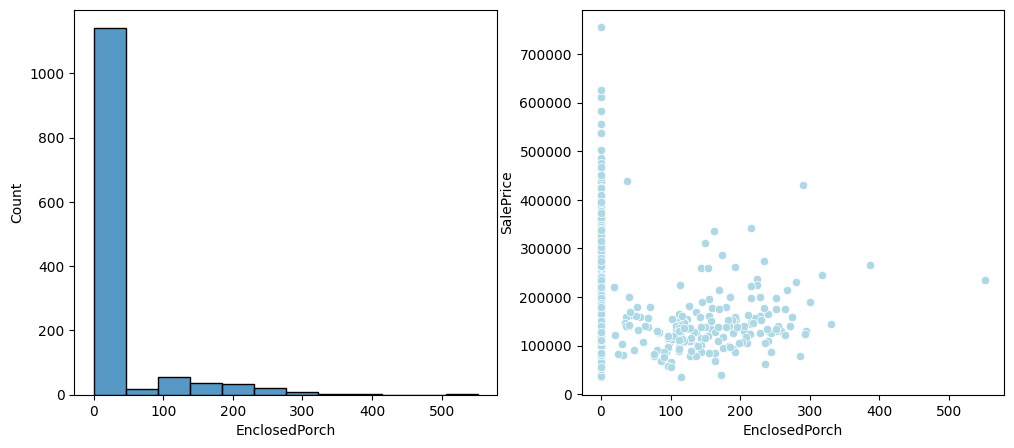

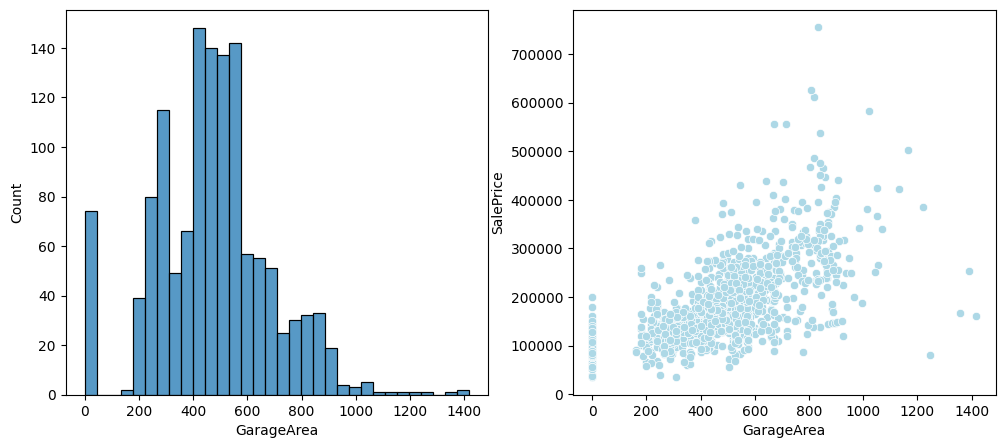

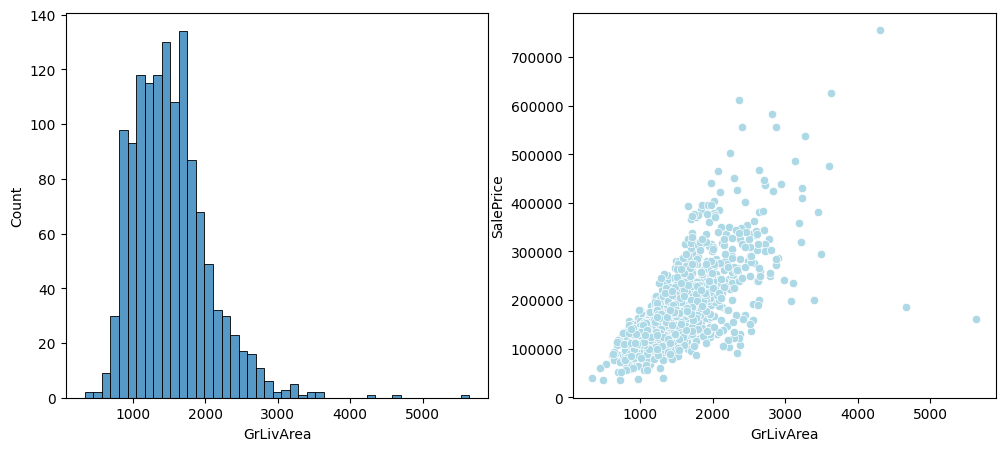

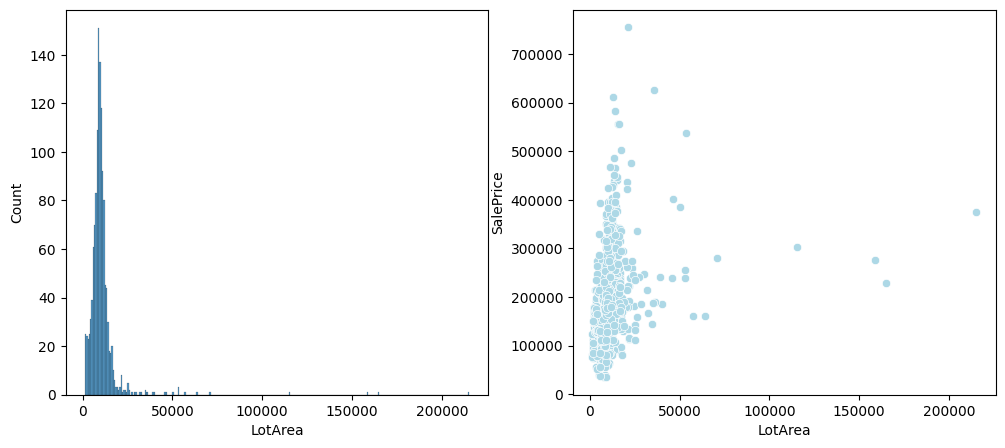

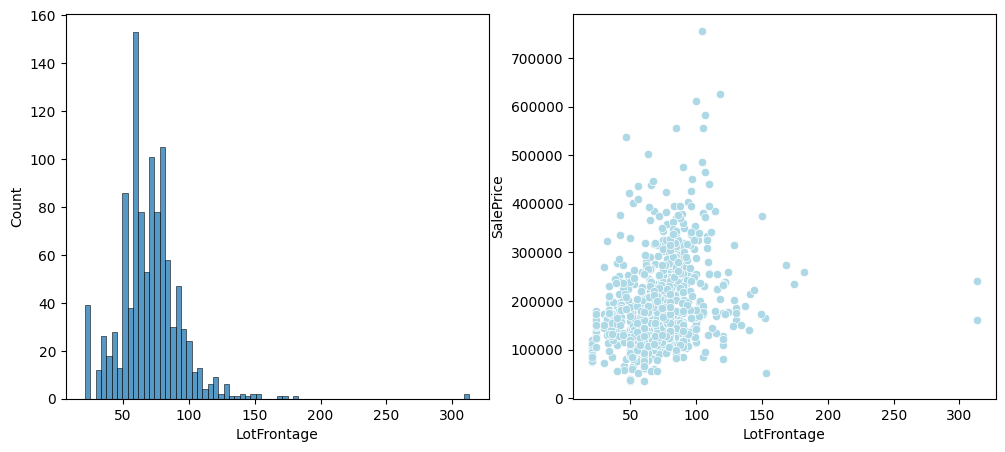

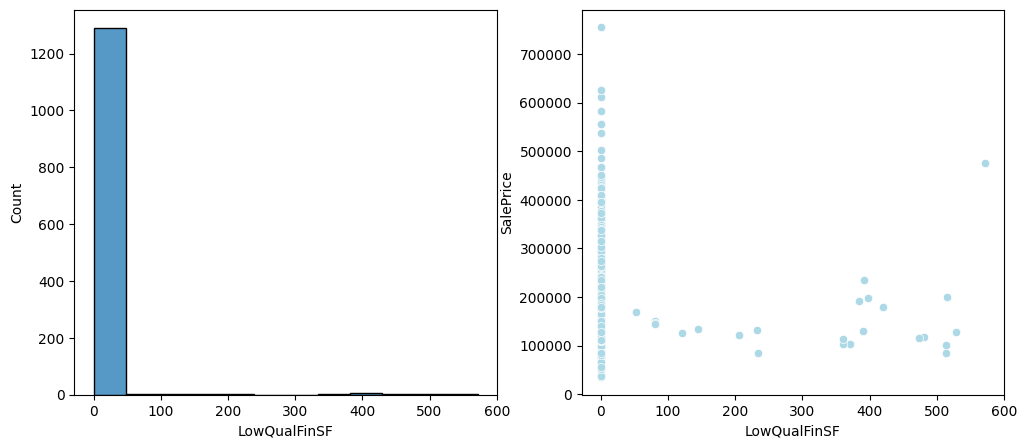

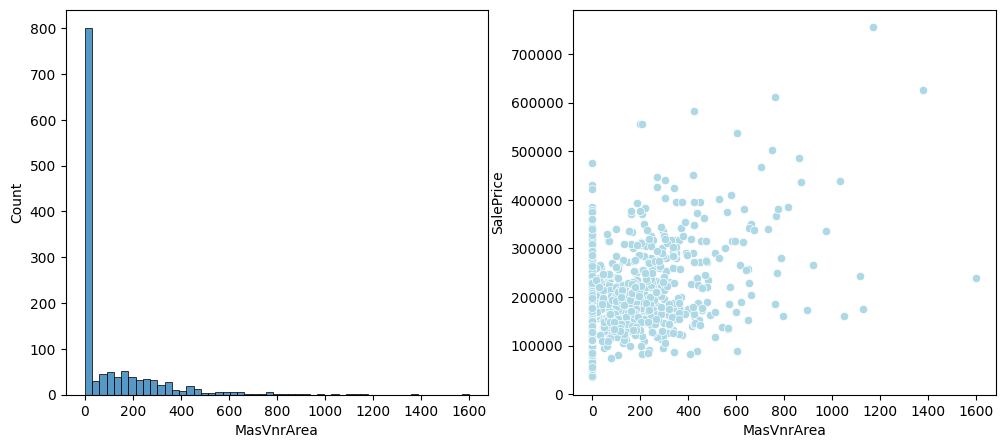

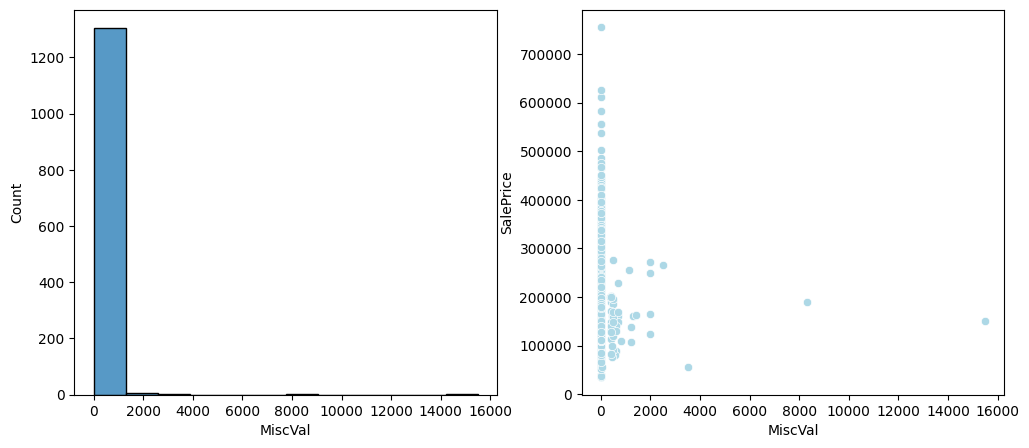

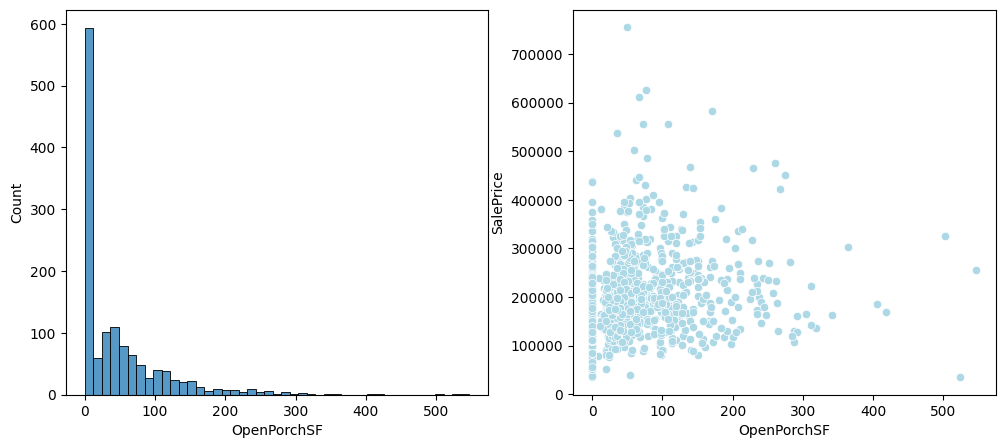

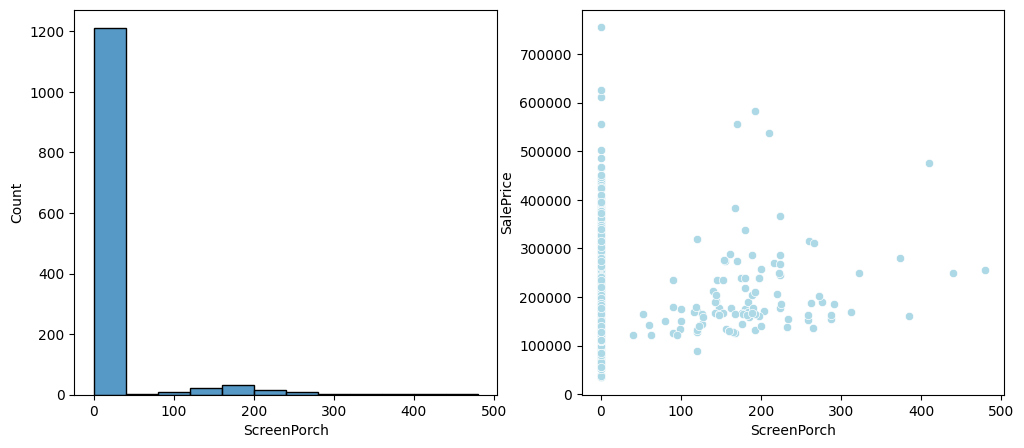

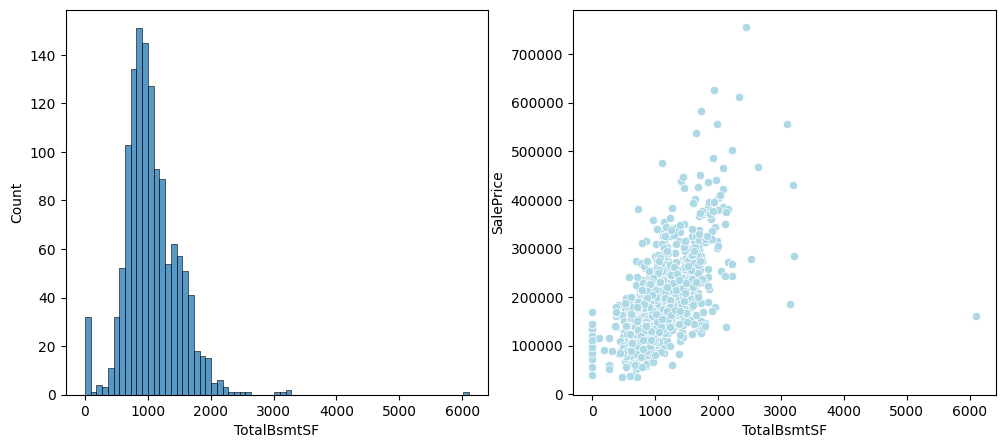

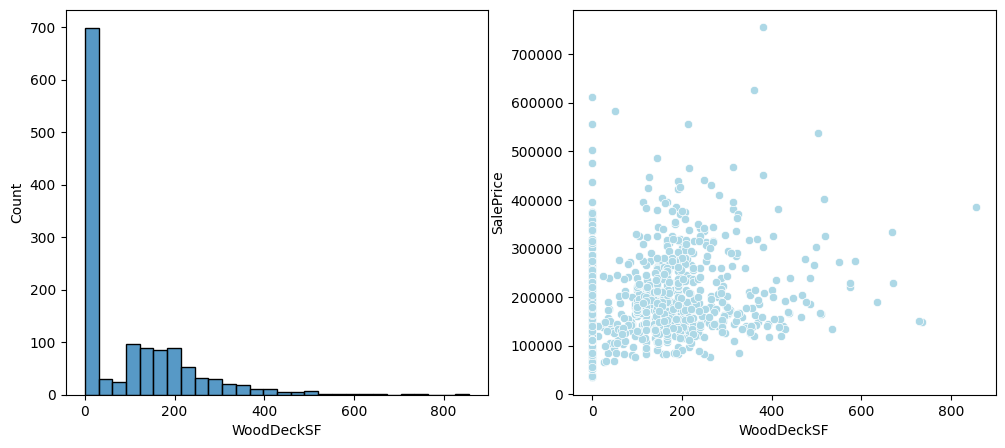

In [31]:
for var in sorted(cont_vars):
    fig, ax = plt.subplots(figsize=(12, 5), nrows=1, ncols=2)
    sns.histplot(data=train, x=var, ax=ax[0])
    sns.scatterplot(data=train, x=var, y='SalePrice', color='lightblue', ax=ax[1])
    plt.show()

Seems like distributions can get quite skewed. This could affect correlation with the target.

We could alleviate skewness by taking log on these variables.

For continuous variables that seemingly take only 1 value, it may be useful to binarise them.

In [32]:
cont_skewed_vars = train[cont_vars].apply(lambda x: skew(x.dropna()))
cont_skewed_vars = cont_skewed_vars[cont_skewed_vars > 0.75]
cont_skewed_vars = cont_skewed_vars.index.tolist()
cont_unskewed_vars = [var for var in cont_vars if var not in cont_skewed_vars]

In [33]:
binarise_vars = [
    'BsmtFinSF2', 'LowQualFinSF', 'EnclosedPorch', 'ScreenPorch', 'MiscVal'
]

In [34]:
def plot_skewed_var_impact(var):
    df = train.copy()
    df[var] = np.where(df[var] == 0, 0, 1)
    df.groupby(var)['SalePrice'].agg(['mean', 'std']).plot(
        kind='barh', xerr='std', figsize=(3, 3));

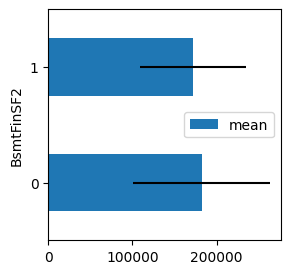

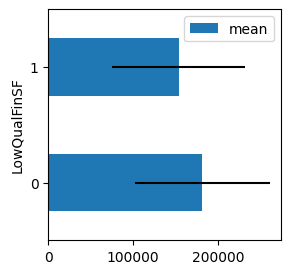

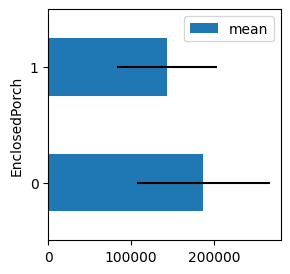

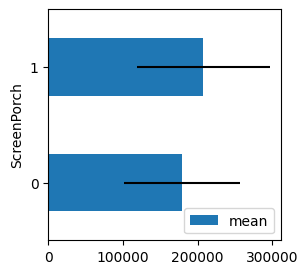

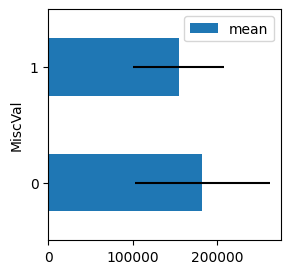

In [35]:
for var in binarise_vars:
    plot_skewed_var_impact(var)

With regards to variables taking predominantly one value, we can see that those values not taking 0 seem to have some contribution in predicting the target.

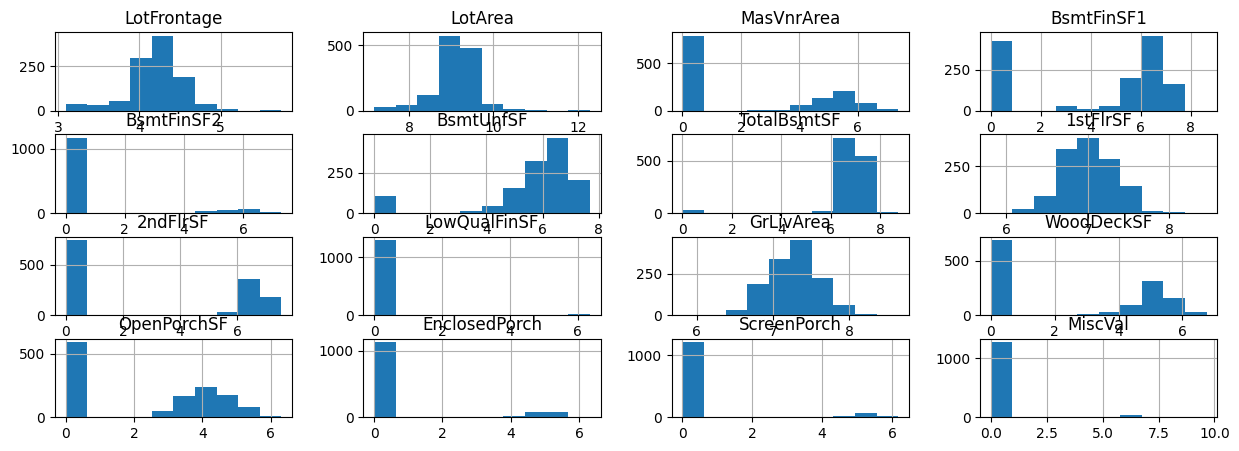

In [36]:
train[cont_skewed_vars].apply(np.log1p).hist(figsize=(15, 5));

Taking log improves distribution for some variables. But those that predominantly take one value don't seem to have their distributions improved much.

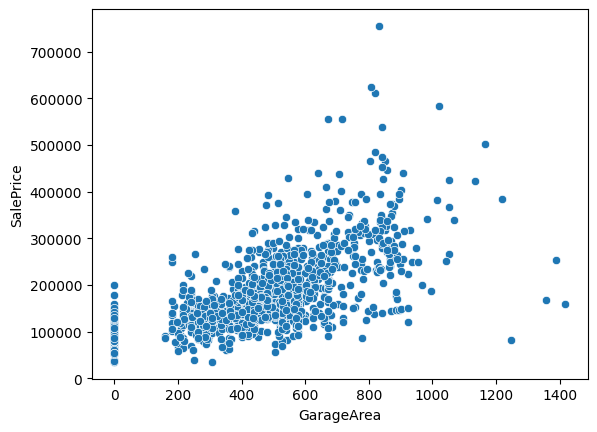

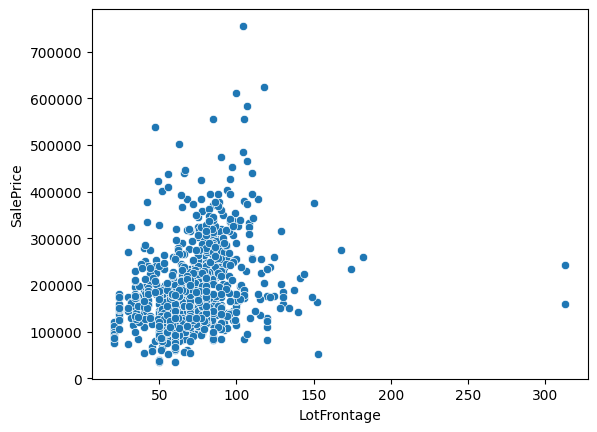

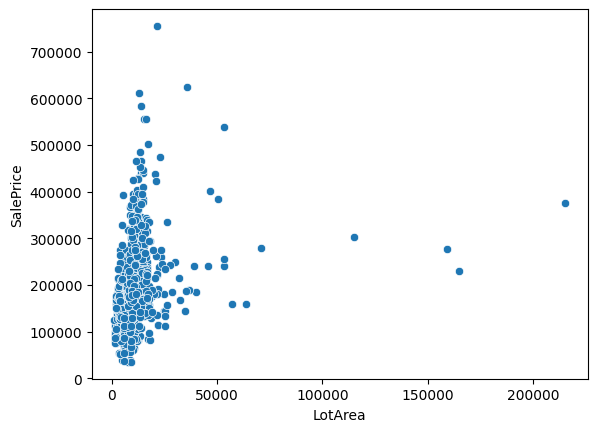

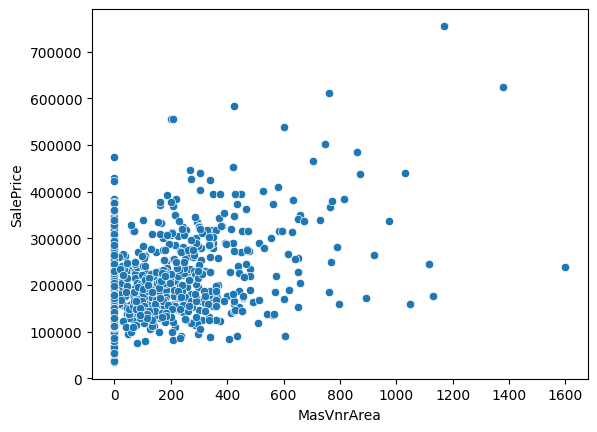

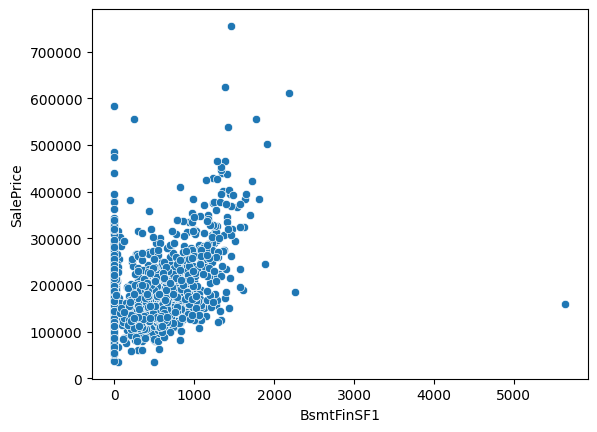

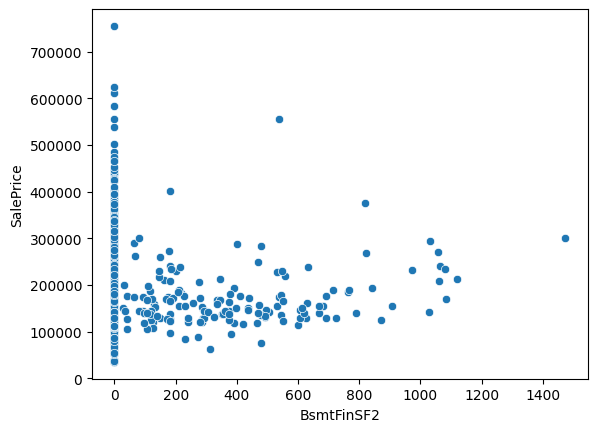

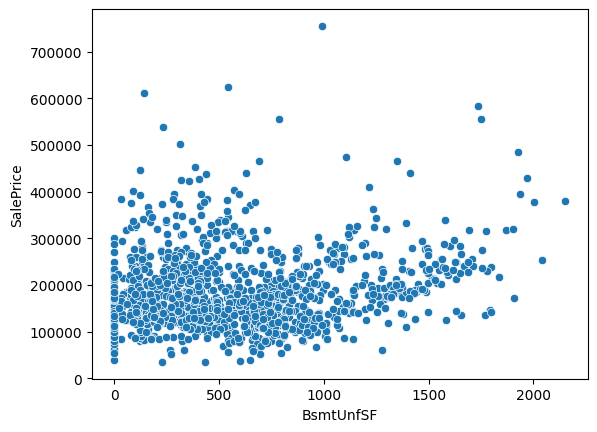

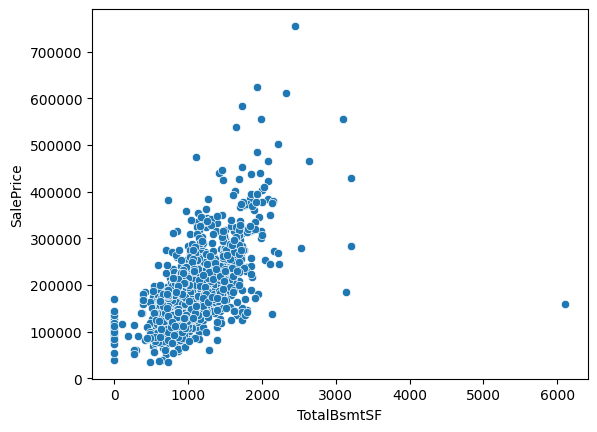

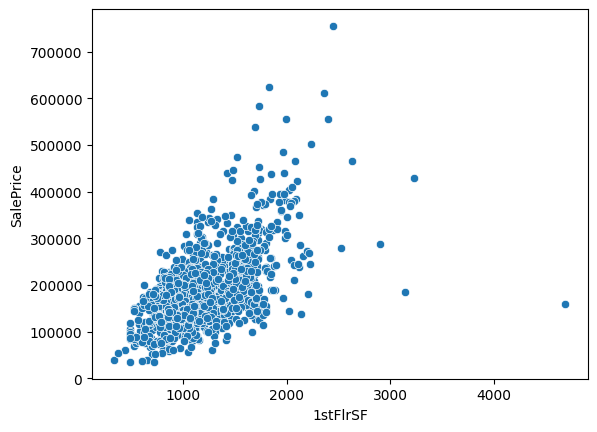

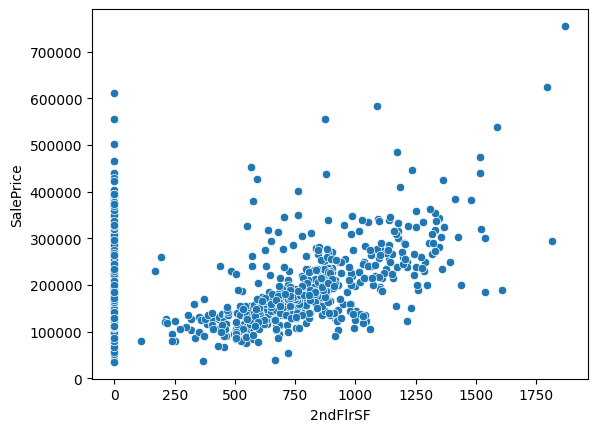

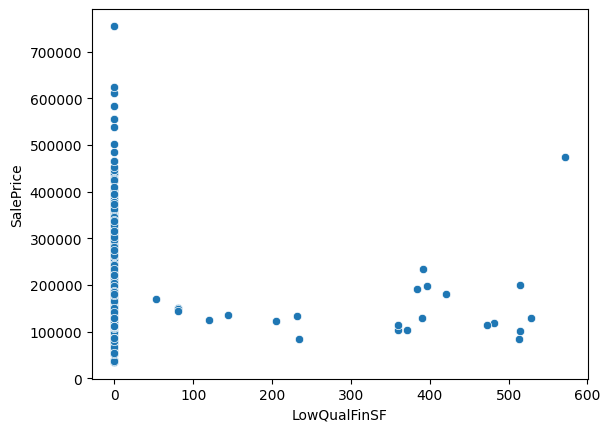

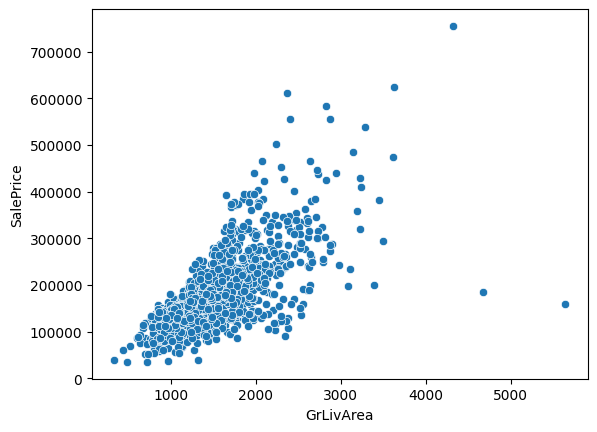

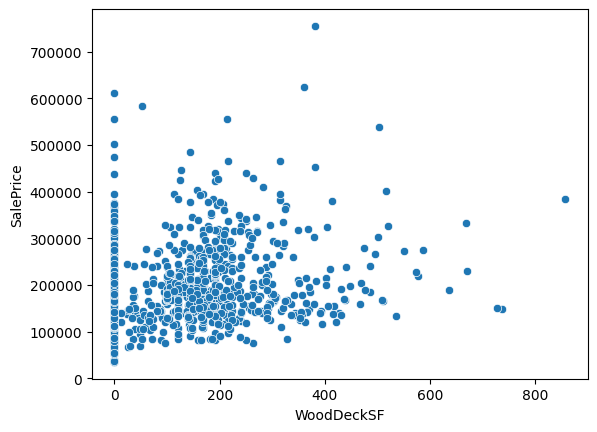

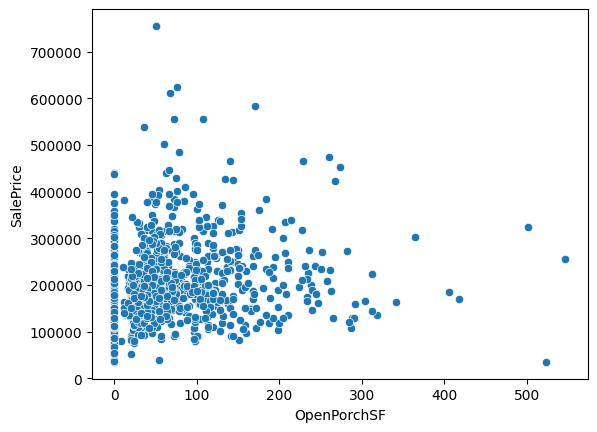

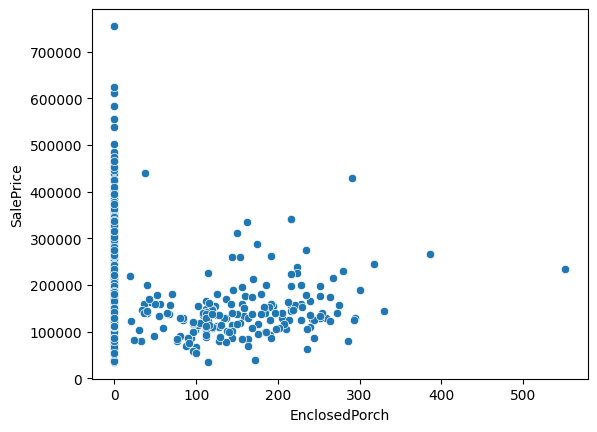

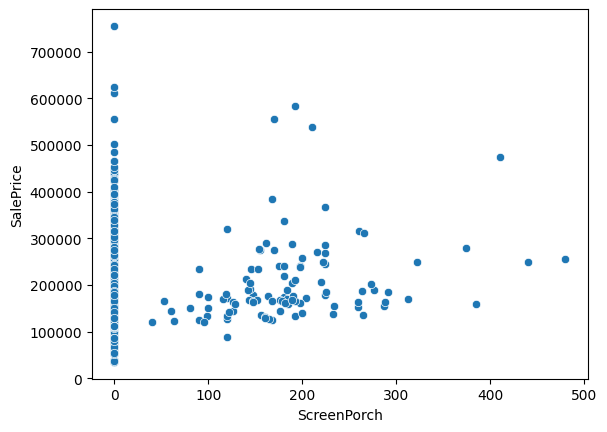

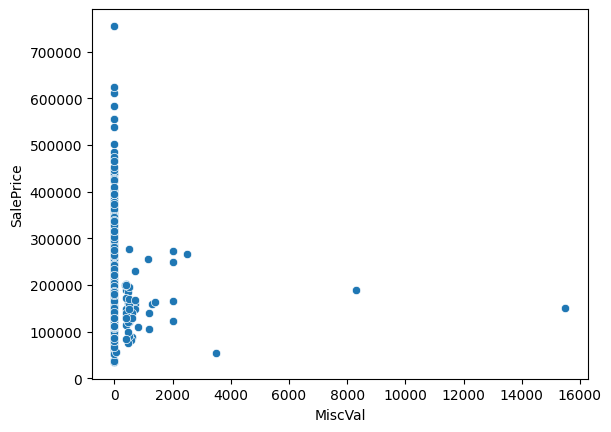

In [37]:
for var in cont_unskewed_vars + cont_skewed_vars:
    sns.scatterplot(x=var, y='SalePrice', data=train)
    plt.show()

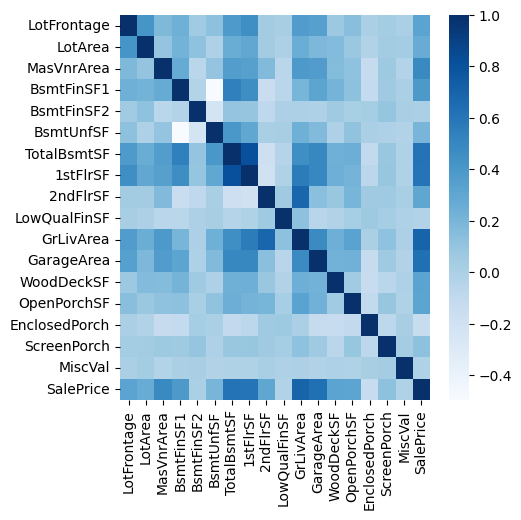

In [38]:
fig, ax = plt.subplots(figsize=(5, 5))
corr = train[cont_vars+['SalePrice']].corr()
cmap = sns.color_palette('Blues', as_cmap=True)
sns.heatmap(corr, cmap=cmap);

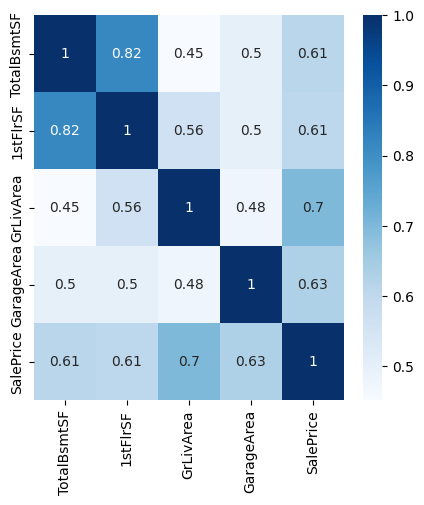

In [39]:
fig, ax = plt.subplots(figsize=(5, 5))
corr = train[cont_vars+['SalePrice']].corr()
good_correl_idx = np.where(abs(corr['SalePrice']) > 0.5)
good_corr = corr.iloc[good_correl_idx[0], good_correl_idx[0]]
# mask = np.triu(np.ones_like(good_corr, dtype=bool))
cmap = sns.color_palette('Blues', as_cmap=True)
sns.heatmap(good_corr, cmap=cmap, annot=True);

In [40]:
tmp = train.copy()
tmp['TotalSF'] = tmp['TotalBsmtSF'] + tmp['1stFlrSF'] + tmp['2ndFlrSF']
tmp['TotPorchSF'] = (tmp['OpenPorchSF'] + tmp['3SsnPorch'] + 
                     tmp['EnclosedPorch'] + tmp['ScreenPorch'] +
                     tmp['WoodDeckSF'])
tmp['TotLivArea'] = tmp['GrLivArea'] + tmp['TotalBsmtSF']

tmp[['TotalSF', 'TotPorchSF', 'TotLivArea', 'SalePrice']].corr()

TotalSF  TotPorchSF  TotLivArea  SalePrice
TotalSF     1.000000    0.400433    0.998201   0.775567
TotPorchSF  0.400433    1.000000    0.401366   0.391604
TotLivArea  0.998201    0.401366    1.000000   0.772668
SalePrice   0.775567    0.391604    0.772668   1.000000

New features are not too bad

## Categoricals

### Cardinality

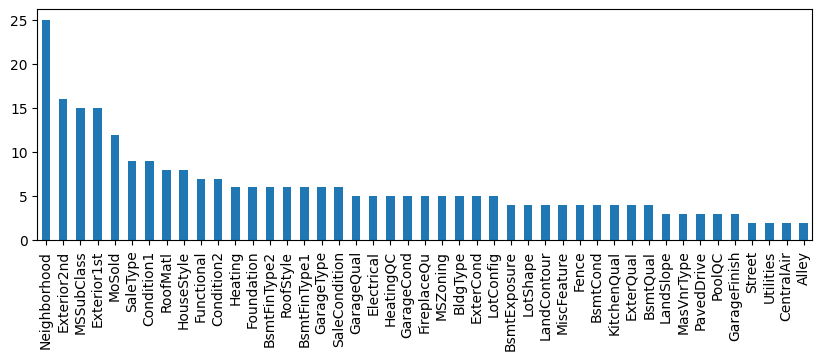

In [41]:
train[cat_vars].nunique().sort_values(ascending=False).plot(kind='bar', figsize=(10, 3));

We see that there aren't any categoricals that take too many types of values, so we may not need to handle high cardinality. However, we will want to look out for the presence of rare labels in each categorical

### Rare labels

In [42]:
def detect_rare_labels(var, pct):
    df = train.copy()
    df[var].value_counts(normalize=True).plot(kind='barh', figsize=(5, 3))
    plt.show()

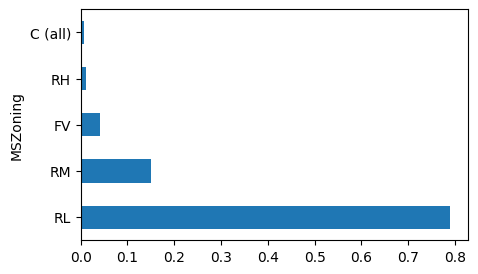

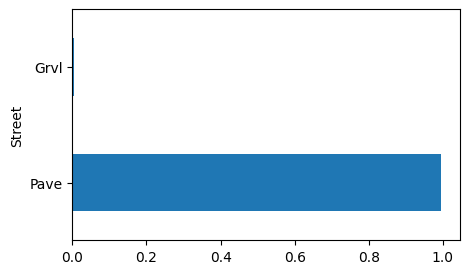

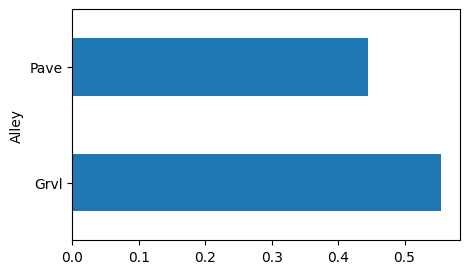

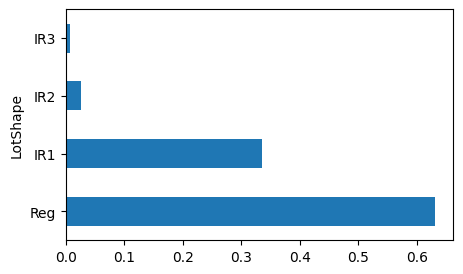

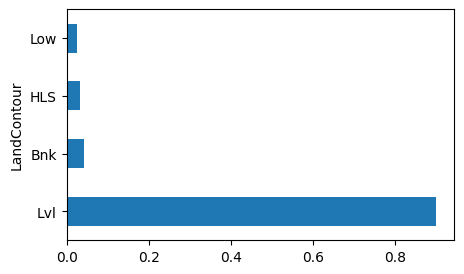

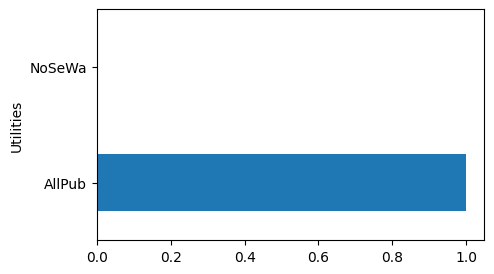

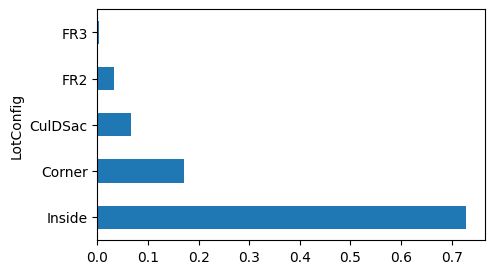

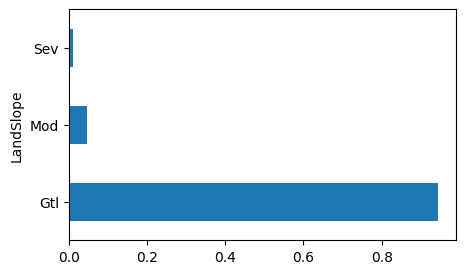

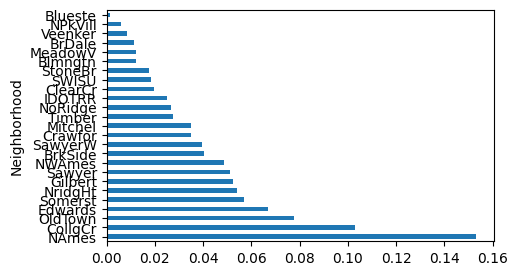

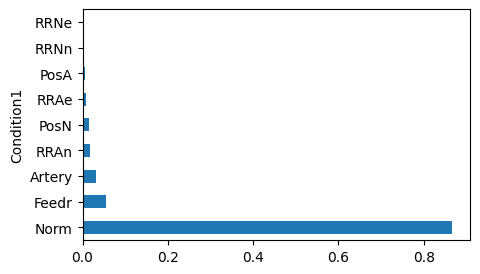

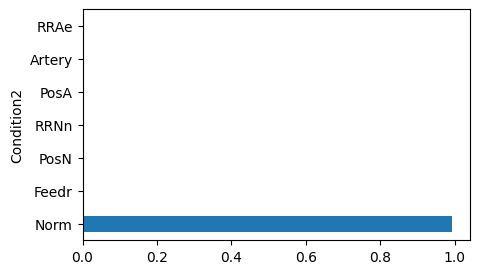

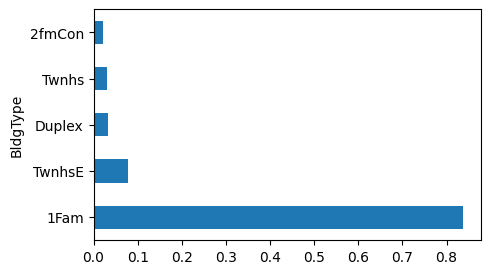

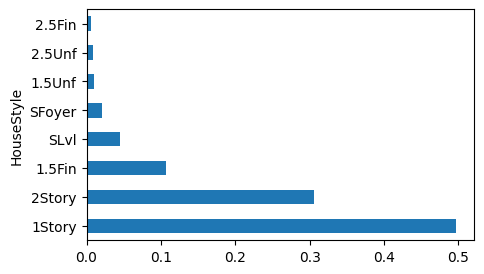

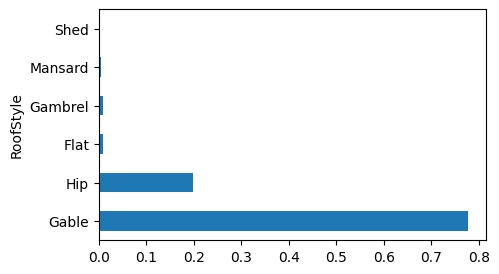

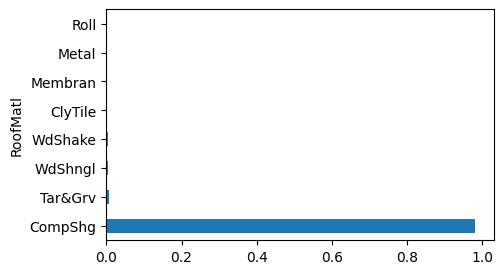

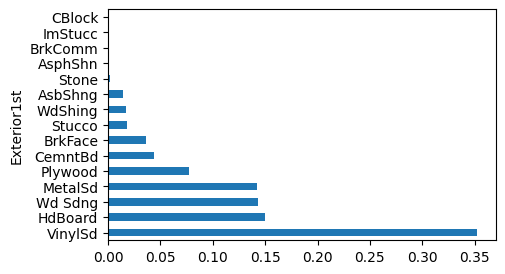

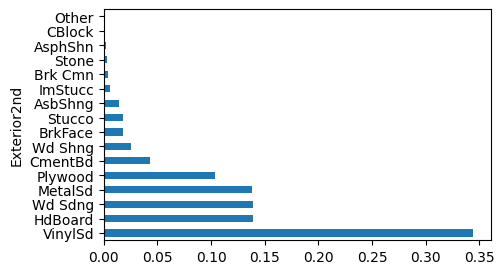

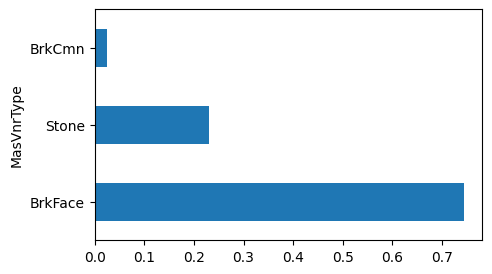

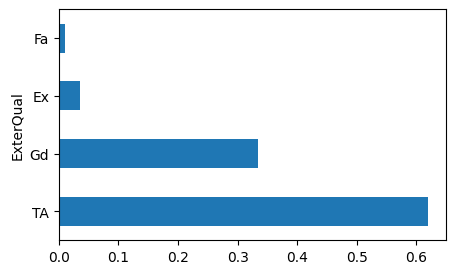

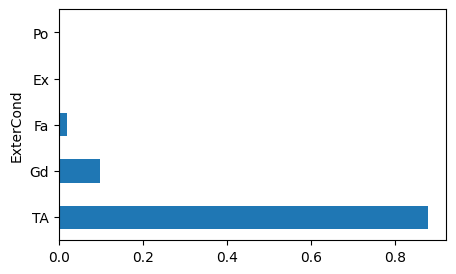

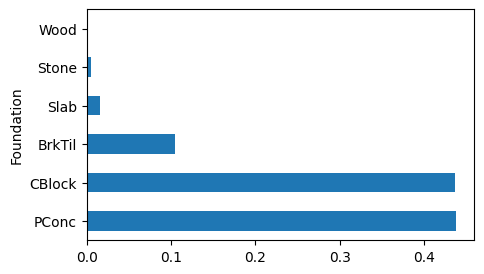

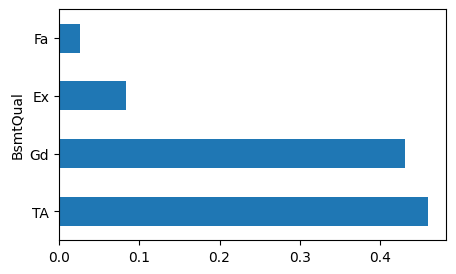

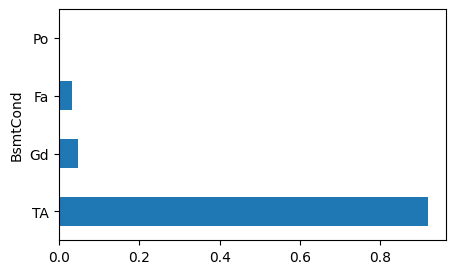

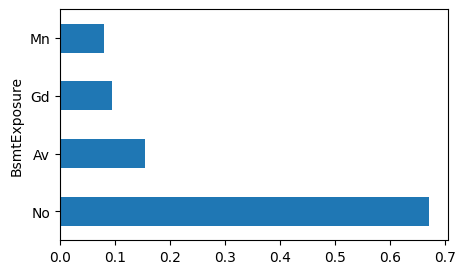

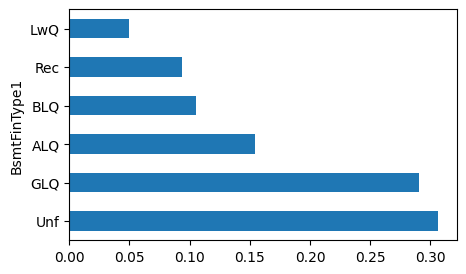

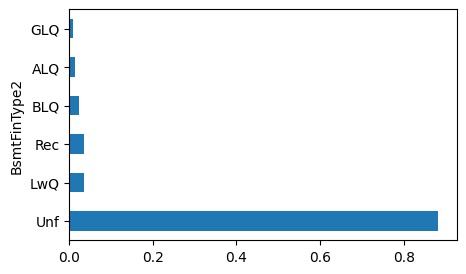

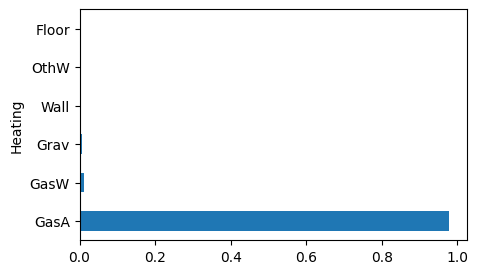

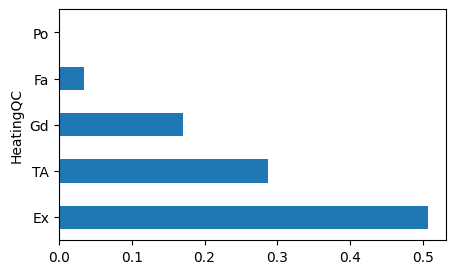

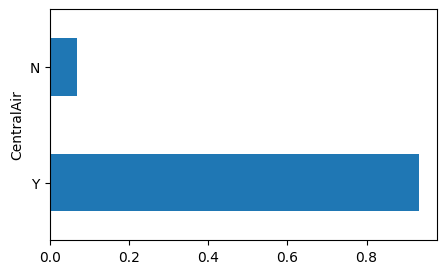

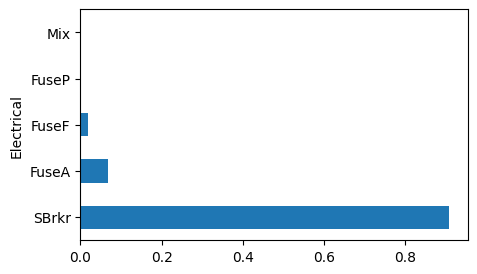

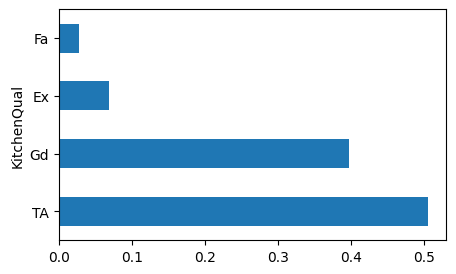

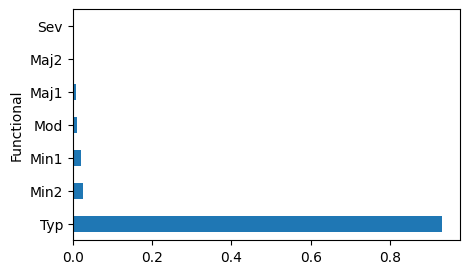

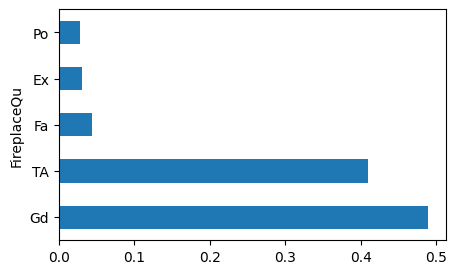

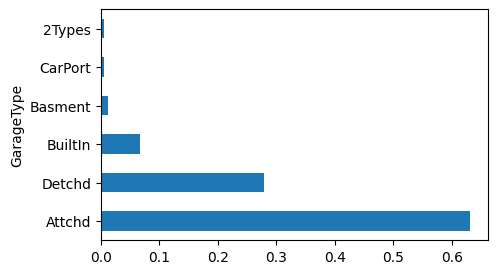

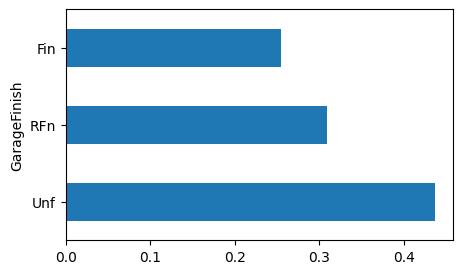

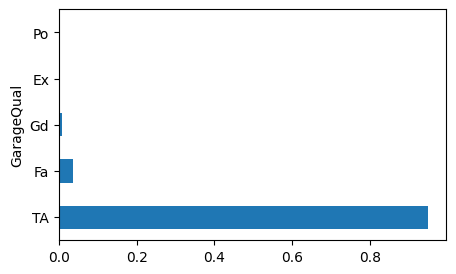

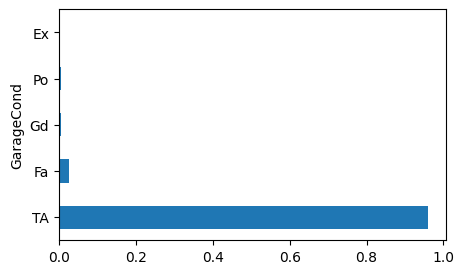

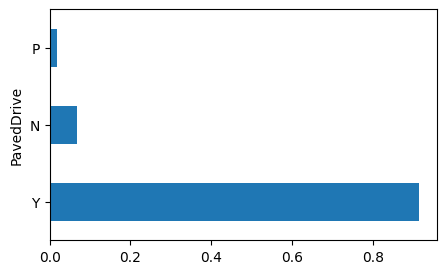

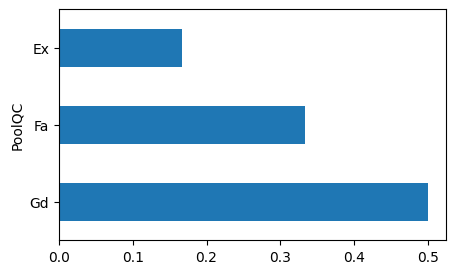

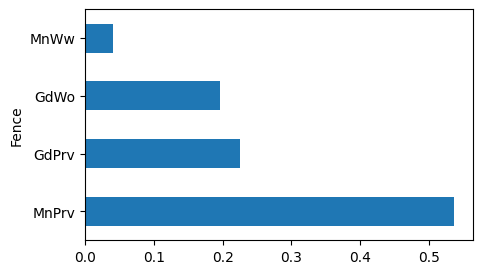

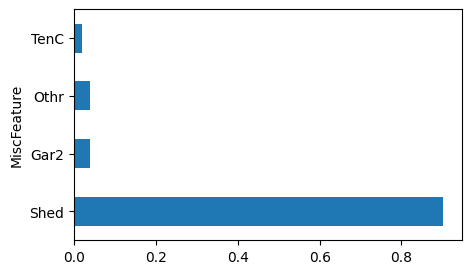

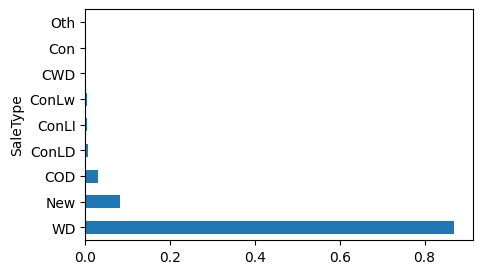

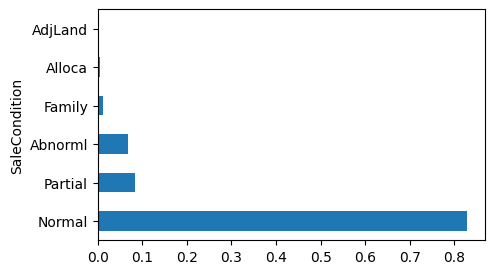

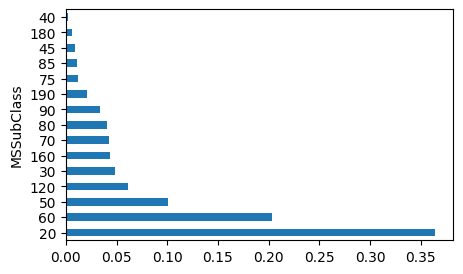

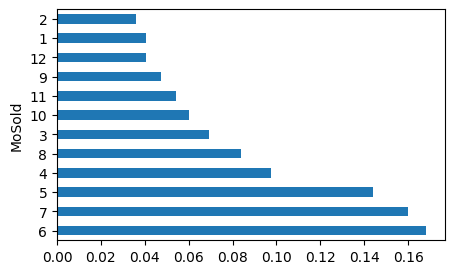

In [43]:
for var in cat_vars:
    detect_rare_labels(var, 0.05)

Anything appearing 5% or less will get thrown into a "Rare" category. This method is effective at handling instances with rare values during deployment

In [44]:
train[cat_vars] = train[cat_vars].astype('object')

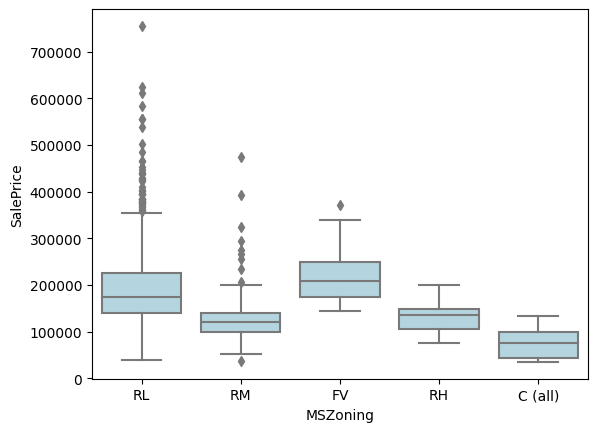

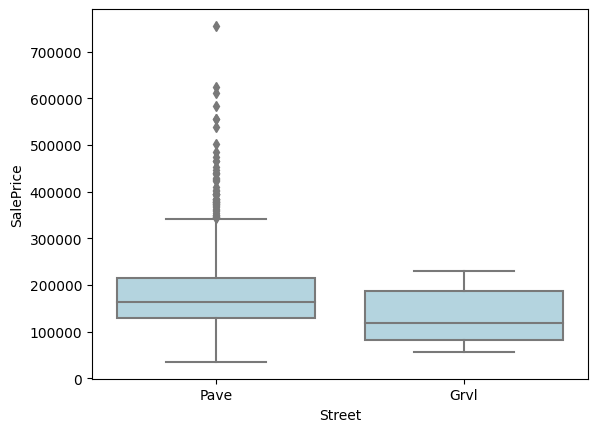

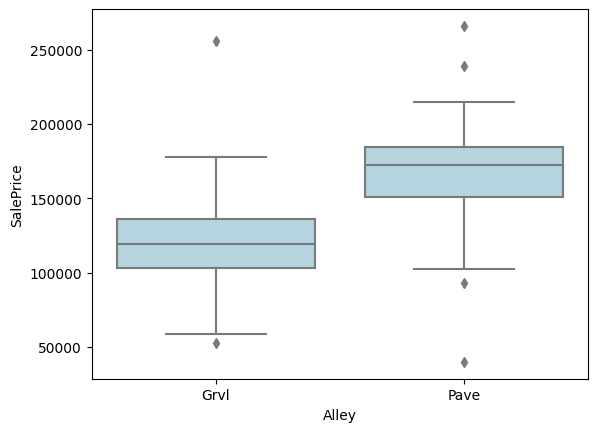

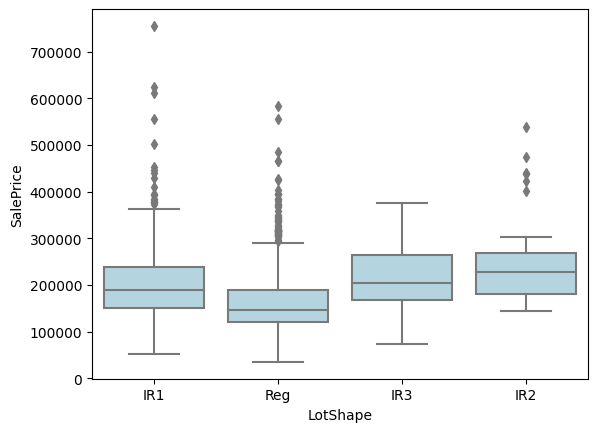

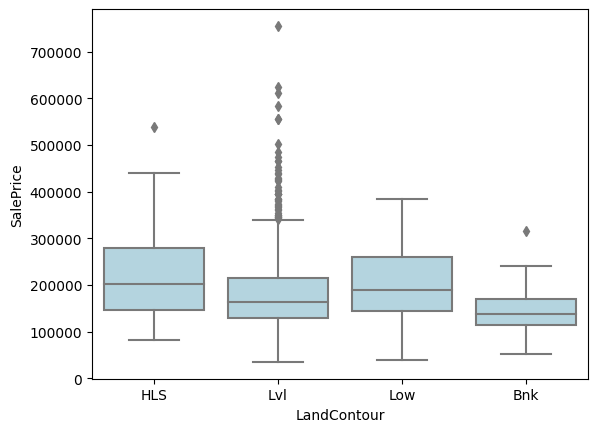

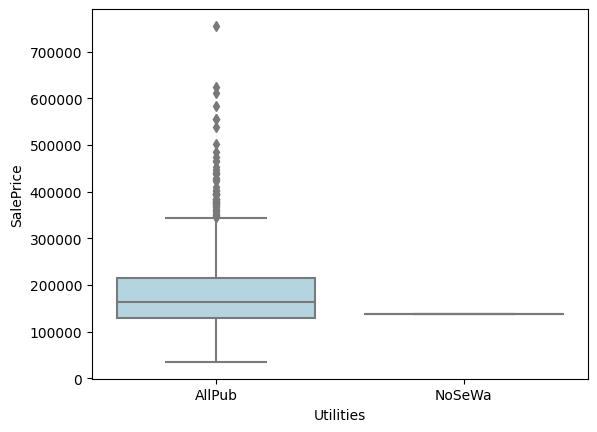

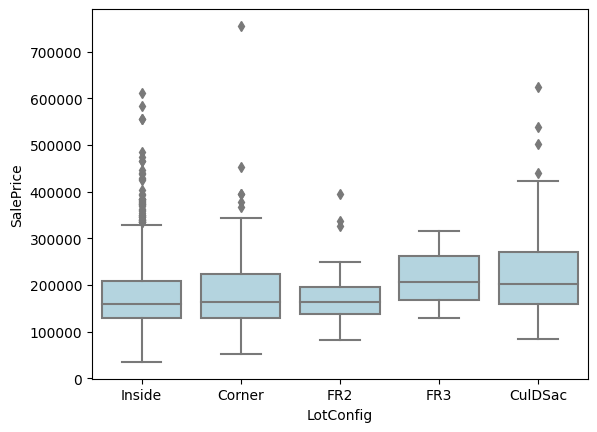

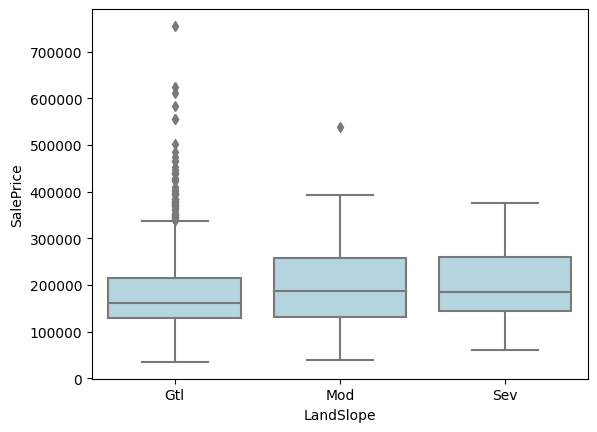

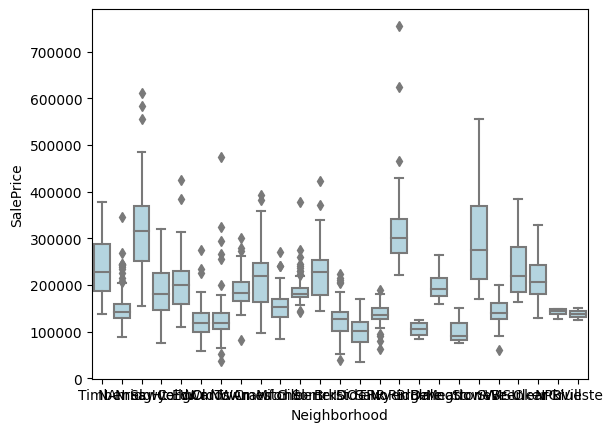

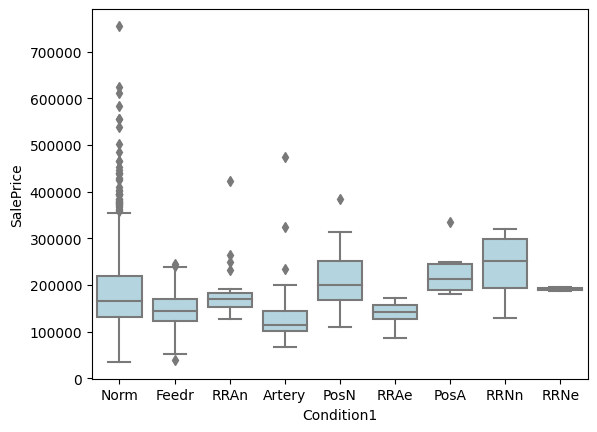

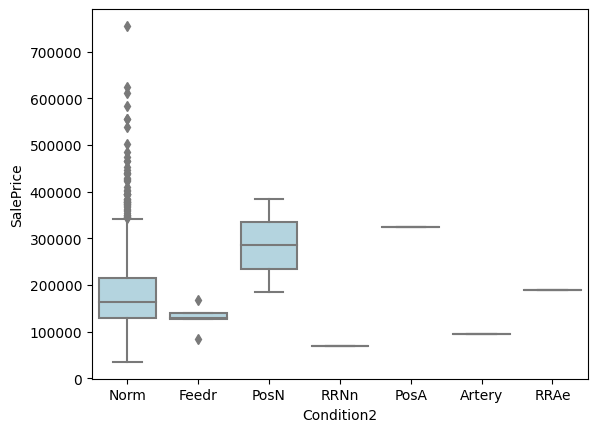

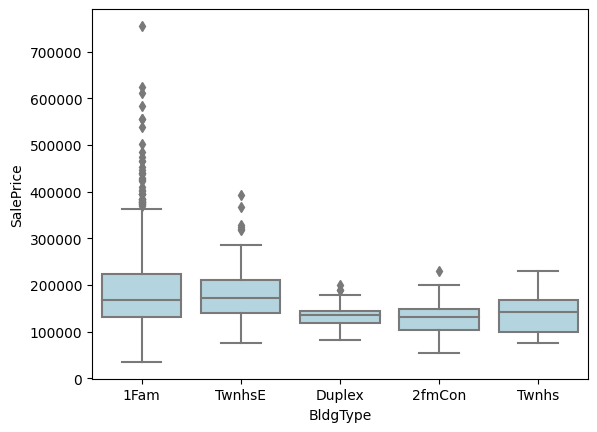

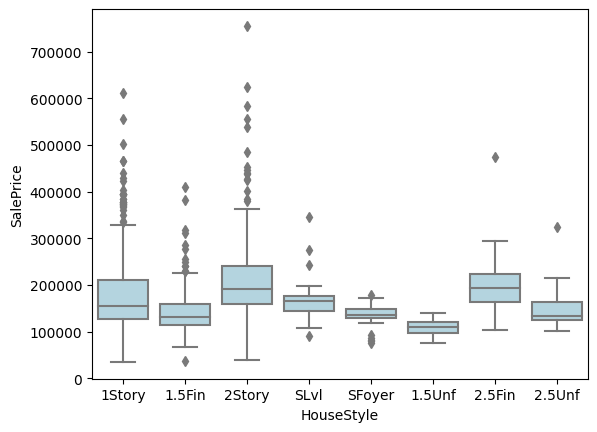

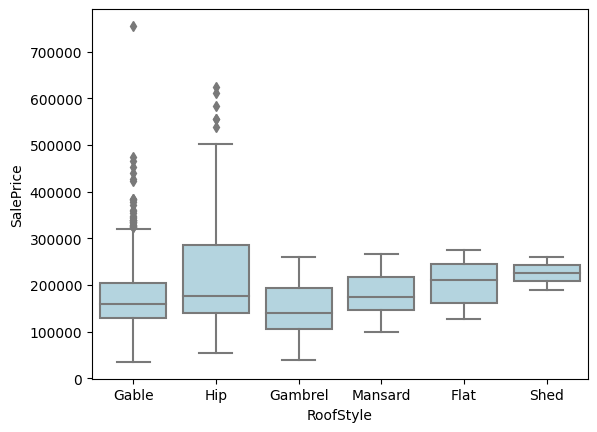

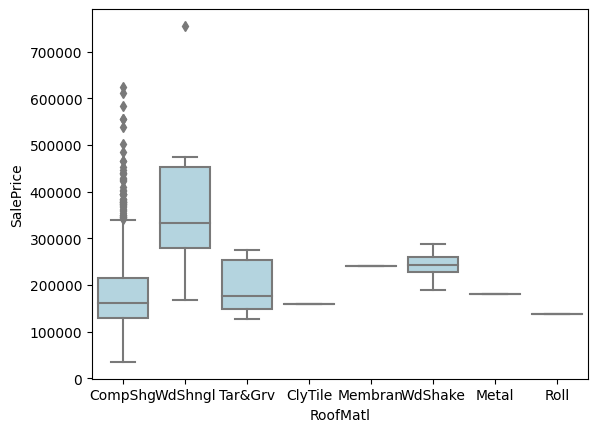

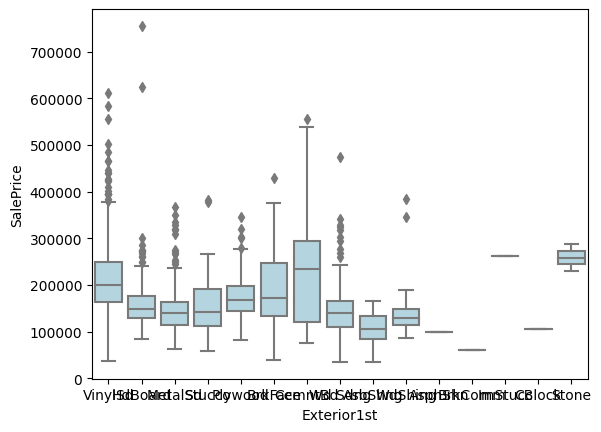

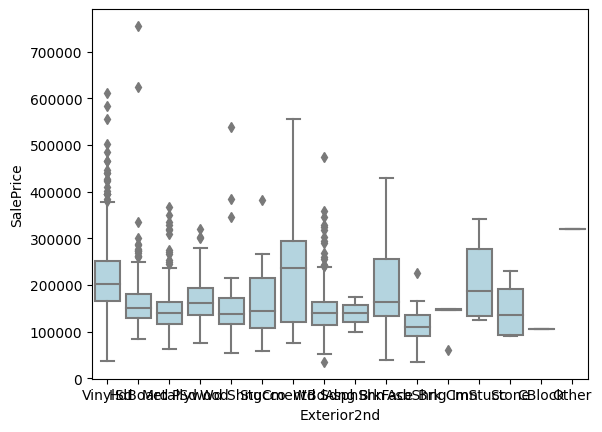

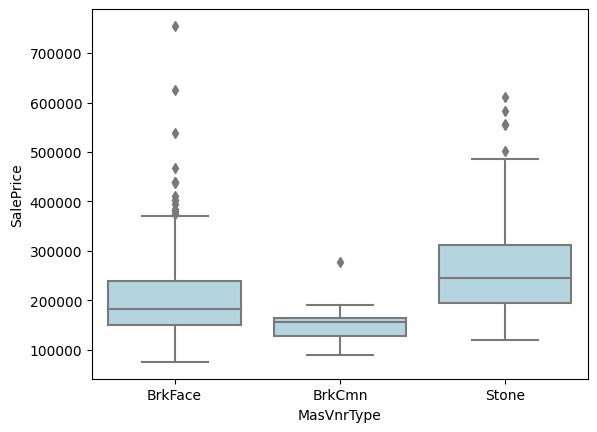

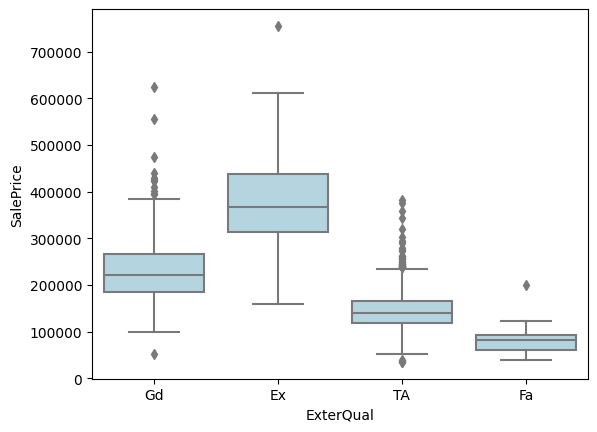

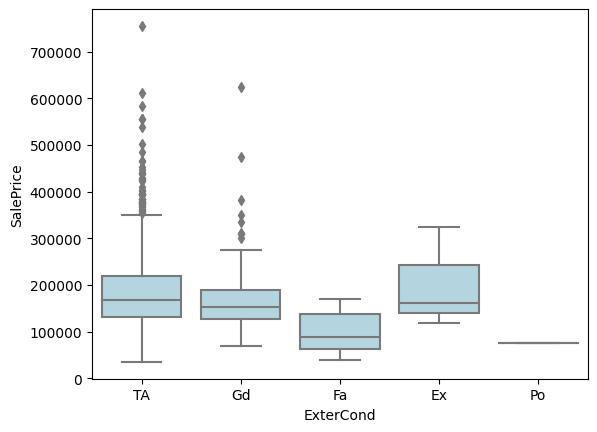

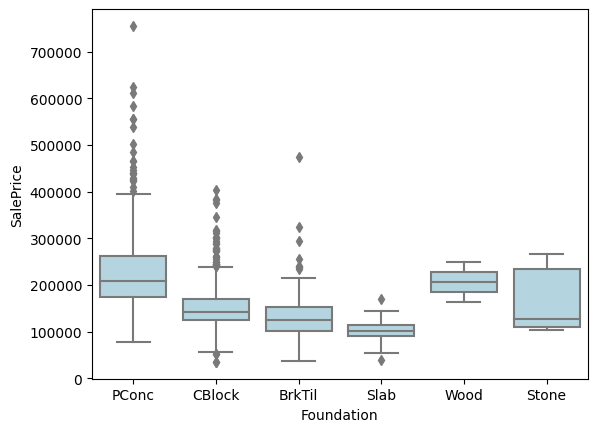

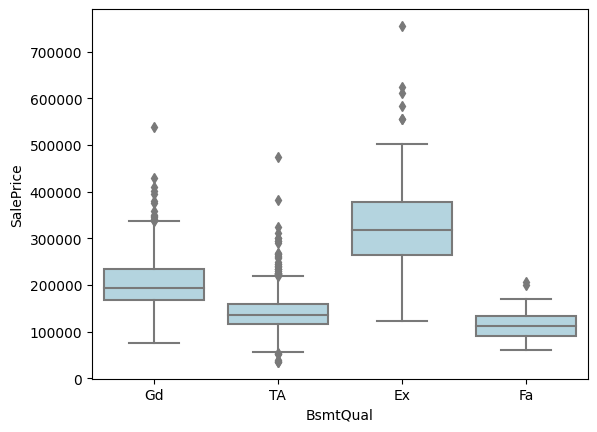

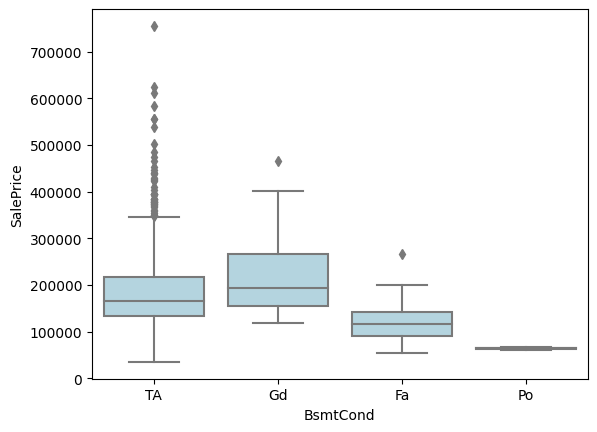

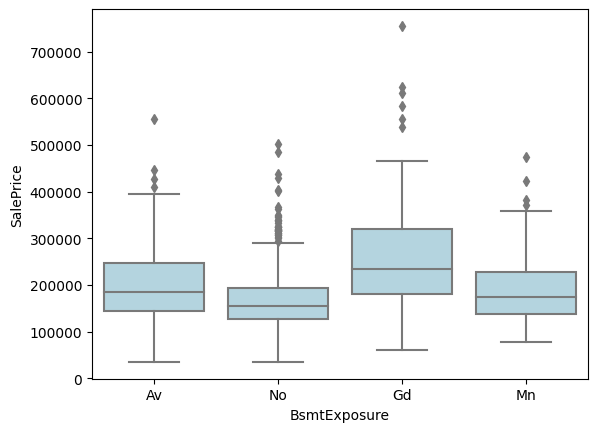

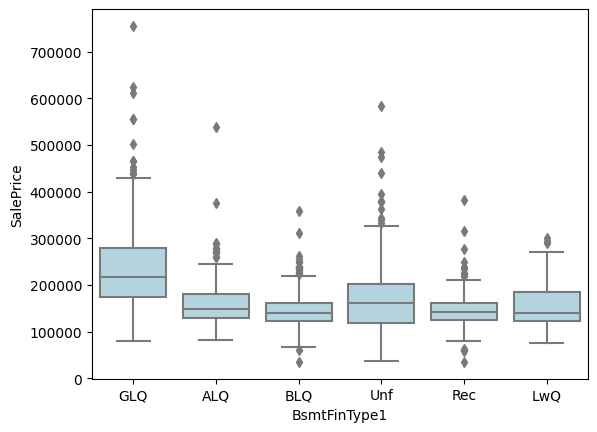

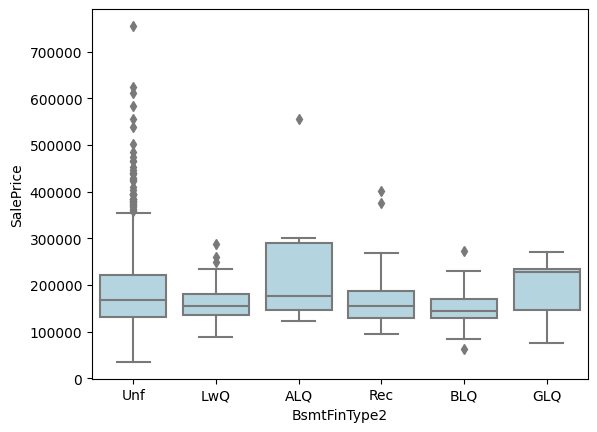

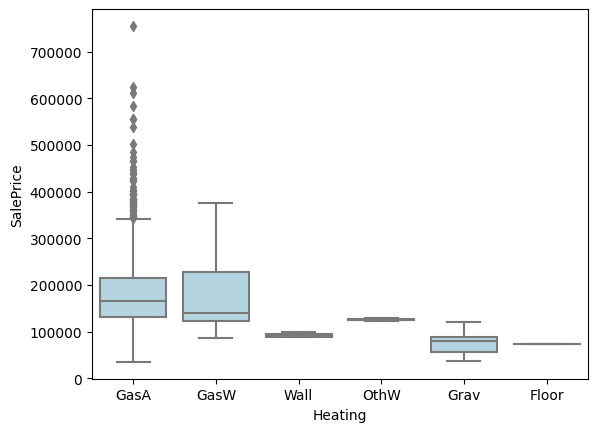

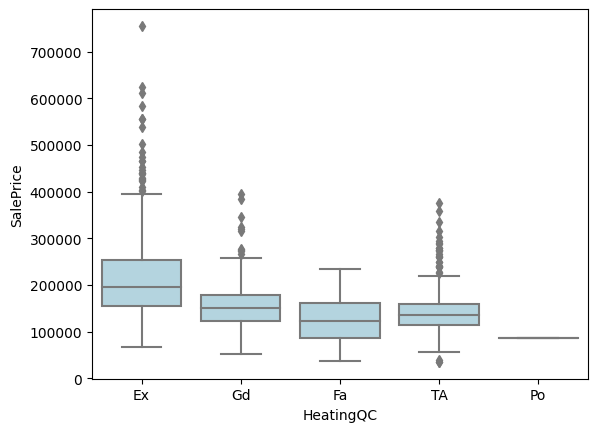

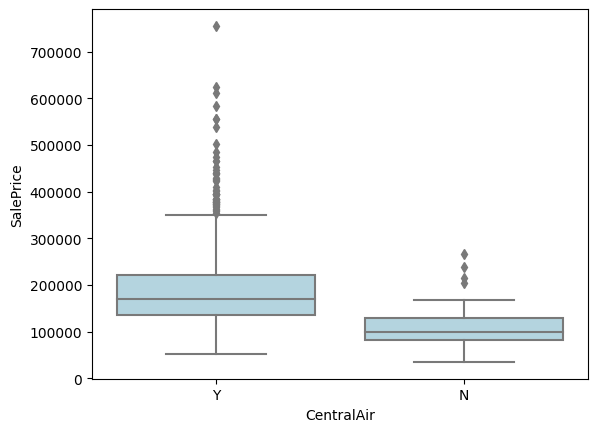

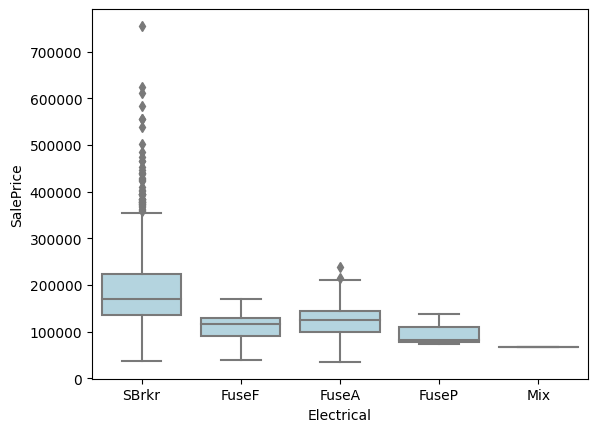

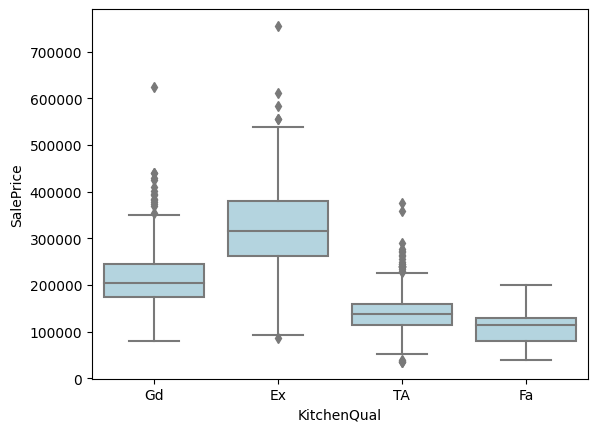

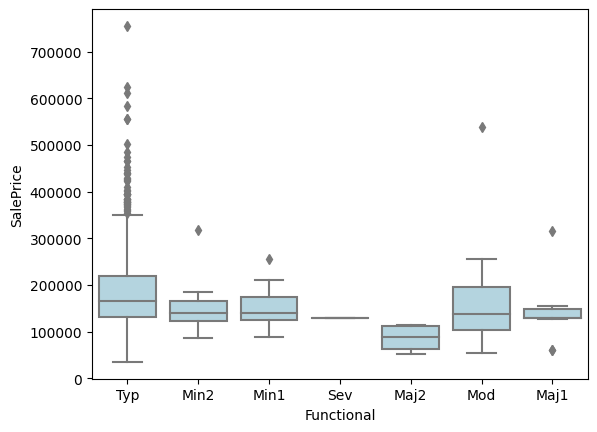

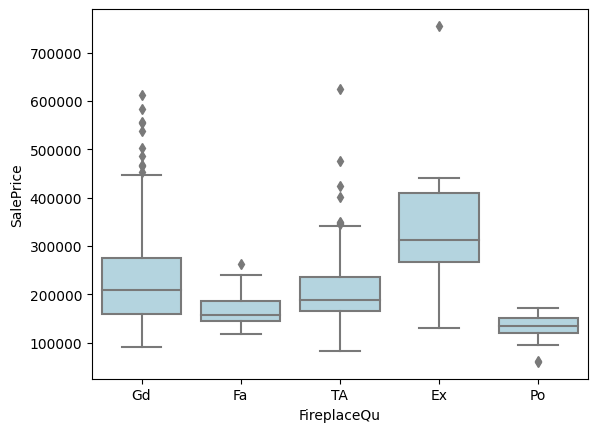

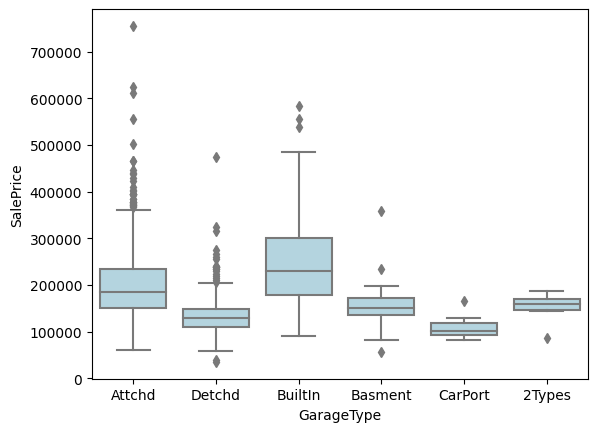

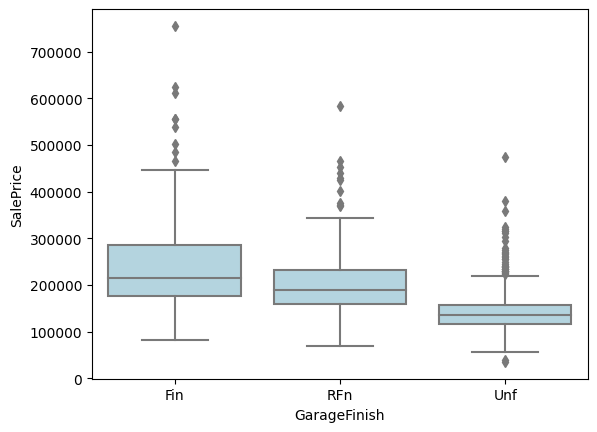

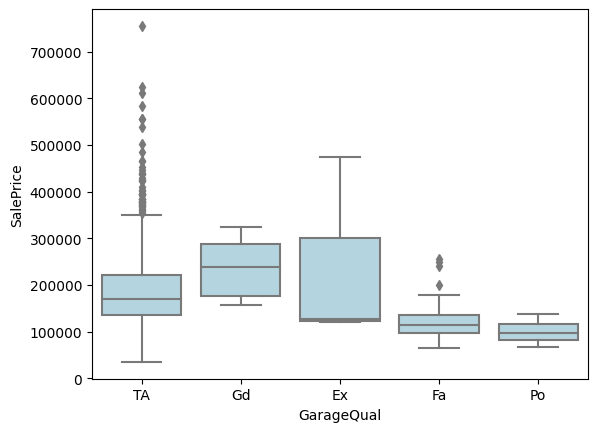

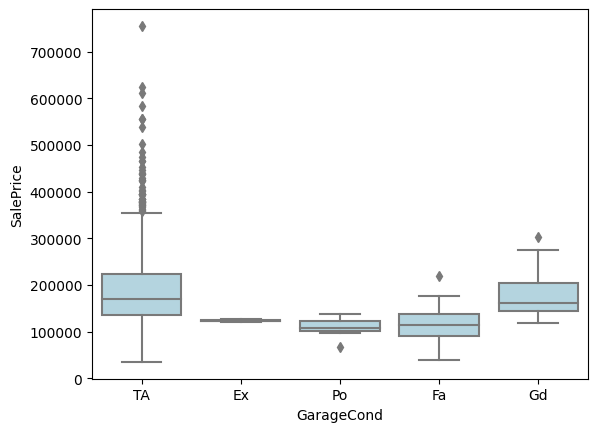

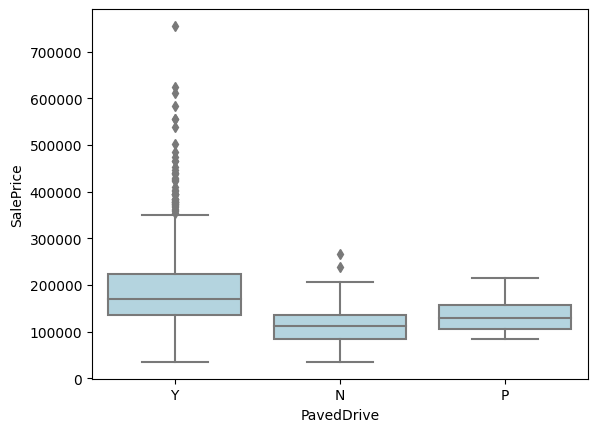

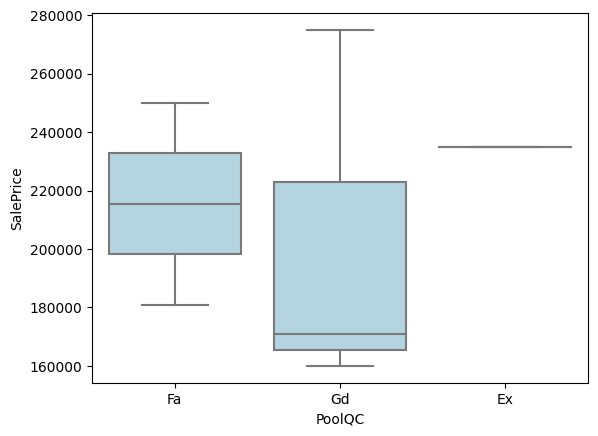

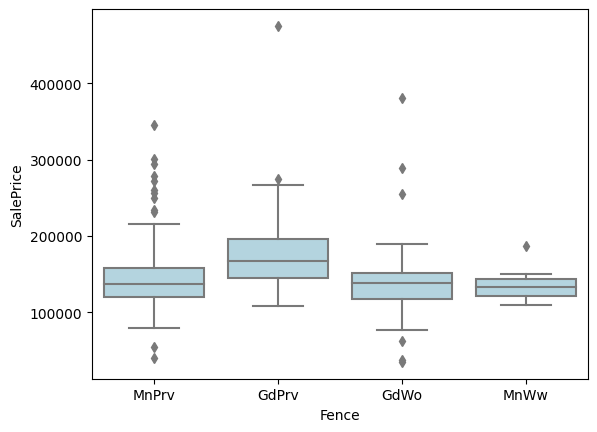

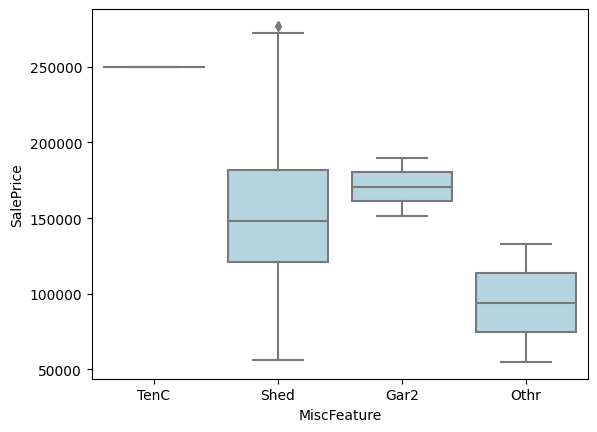

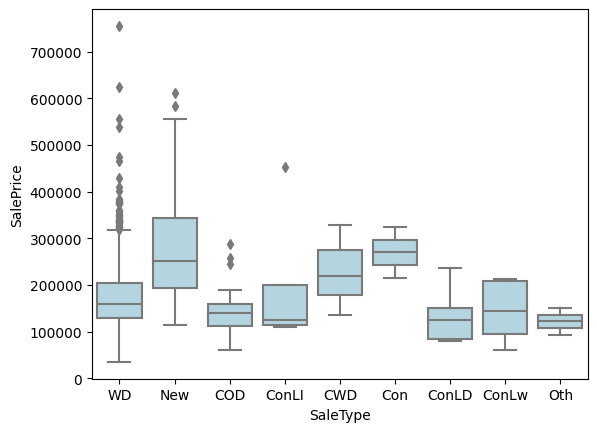

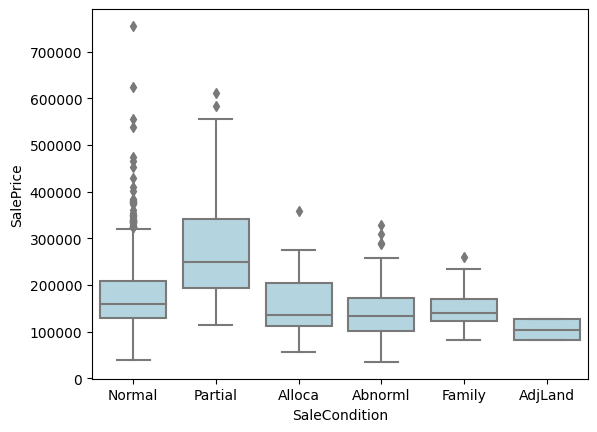

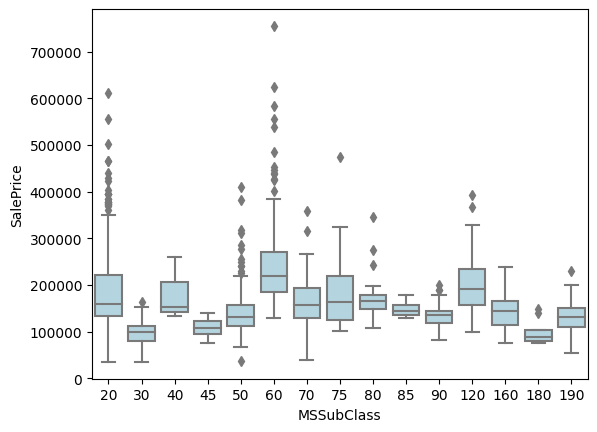

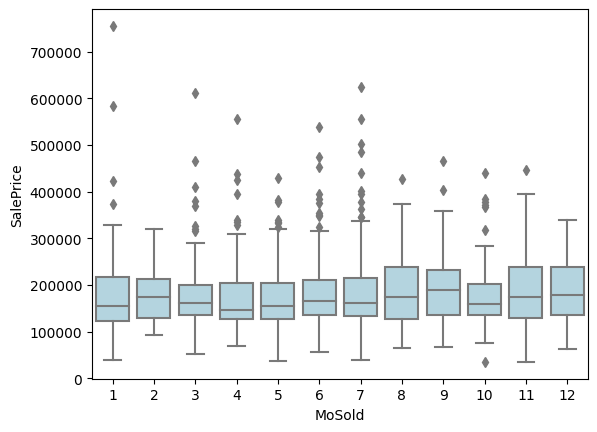

In [45]:
for var in cat_vars:
    sns.boxplot(data=train, x=var, y='SalePrice', color='lightblue')
    plt.show()

Some categoricals that stand out are:
- Neighbourhood
- Exterior related features
- MSSubClass
- SaleType

We could induce some linearity by label encoding these each variable in accordance with the mean sale price per category.

## Missing

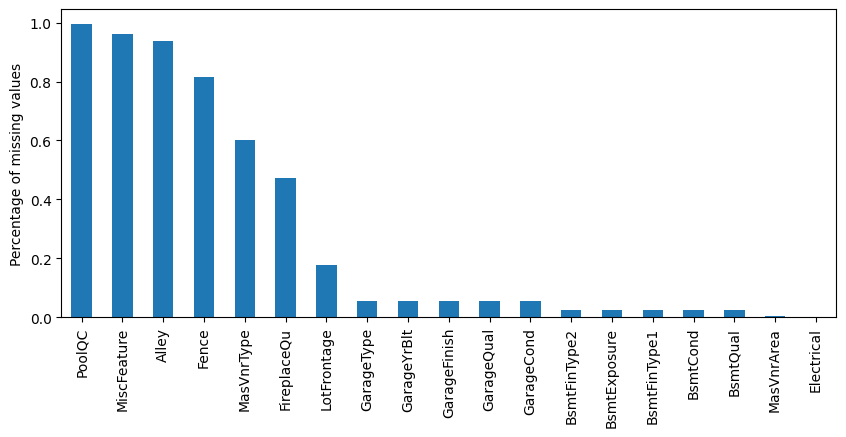

In [46]:
train[na_vars].isnull().mean().sort_values(ascending=False).plot(
    kind='bar', figsize=(10, 4), ylabel='Percentage of missing values');

For garagetype onwards, not so many nulls. Consider: Simple impute with mean/median/mode and adding a marker OR dropping rows OR arbitrary value imputation

PoolQC, MiscFeature, Alley, Fence have a lot of nulls. If these variables don't show a lot of impact on the target, can consider dropping them. If there seems to be value in retaining them, then consider arbitrary value imputation

MasVnrTYpe, FirePlaceQU, LotFrontage have more than 5% missing. Can consider using arbitrary value imputation

In [47]:
def plot_na_var_impact(var):
    df = train.copy()
    df[var] = np.where(df[var].isna(), 1, 0)
    df.groupby(var)['SalePrice'].agg(['mean', 'std']).plot(
        kind='barh', y='mean', xerr='std', figsize=(3, 3));

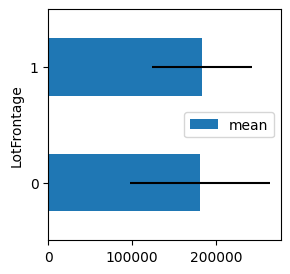

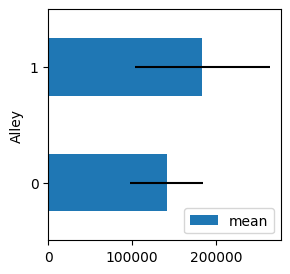

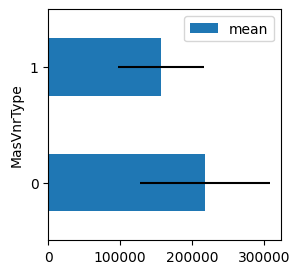

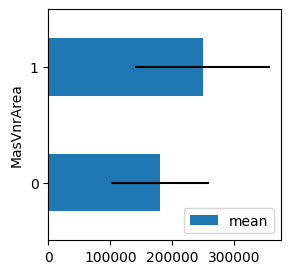

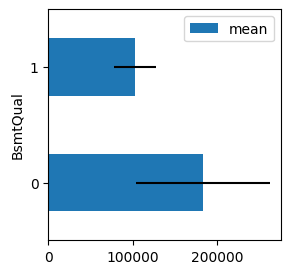

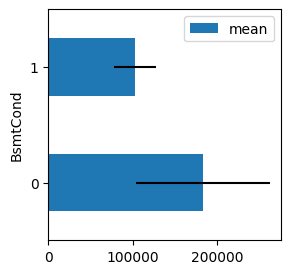

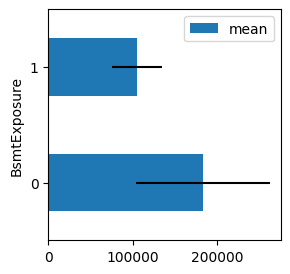

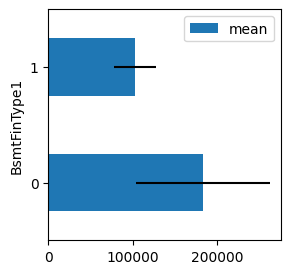

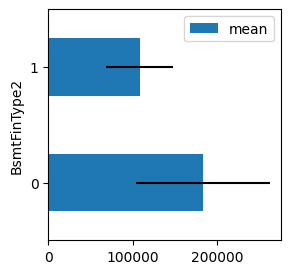

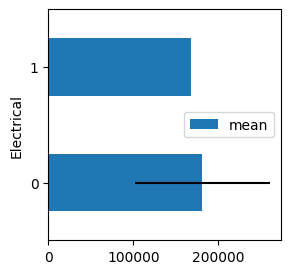

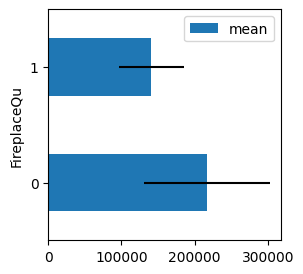

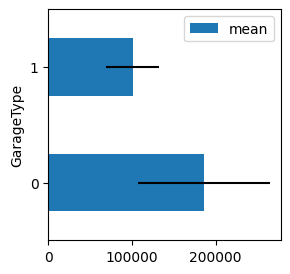

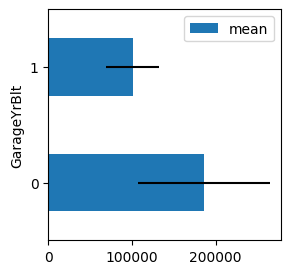

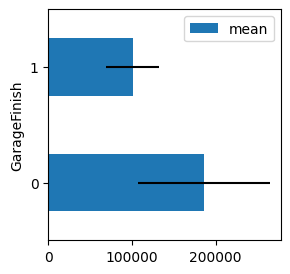

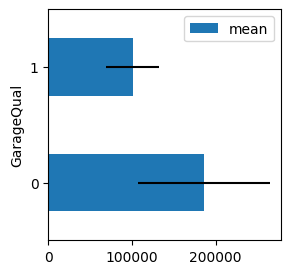

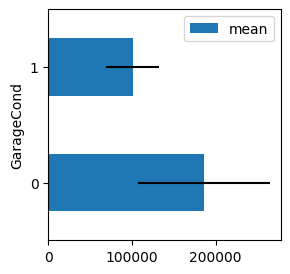

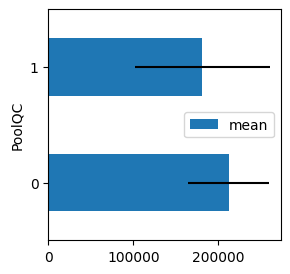

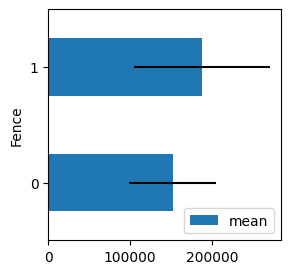

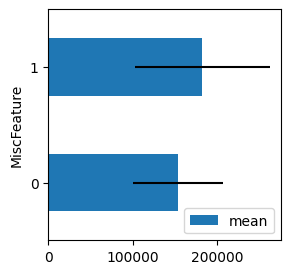

In [48]:
for var in na_vars:
    plot_na_var_impact(var)

We can observe that missing values in all features except LotFrontage and Electrical demonstrate predictive capabilities. This means we don't drop the features even if they contain many nulls. 

Consider mean/median/mode or arbitrary value imputation or really just use common sense to impute

In [49]:
cat_na_vars = [var for var in na_vars if var in cat_vars]

In [50]:
num_na_vars = [var for var in na_vars if var in num_vars]

In [51]:
cat_na_vars

['Alley',
 'MasVnrType',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature']

After doing some exploring and reading:

- Garage is an ordinal variable that takes NA values to mean no garage.

- Basement variables are ordinal and NA just means no basement

- Alley is a nominal categorical that takes NA to mean no alley.

- MasVnrType is a nominal categorical that takes NA to mean no masonry

- Only 1 missing in Electrical. Just impute with mode.

- FireplaceQu is an ordinal categorical that can take NA to mean no fireplace.

- PoolQC is an ordinal categorical that can take NA to mean no pool.

- Fence is an ordinal categorical that can take NA to mean no fence.

- MiscFeature is a nominal categorical that takes NA to mean no misc.

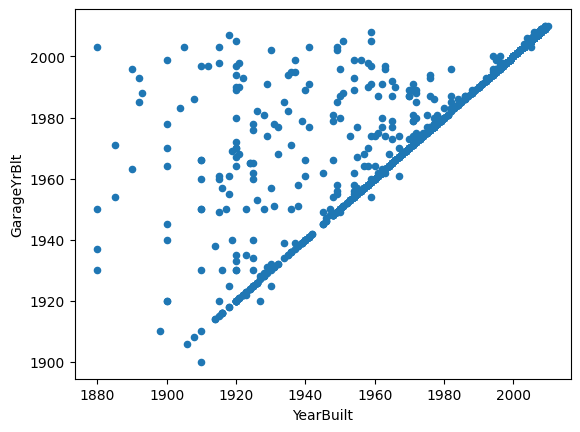

In [52]:
train.plot(kind='scatter', x='YearBuilt', y='GarageYrBlt');

We can see that typically, the garage is built in the same year as the house. Thus if we don't know when the garage was built, it's reasonable to assume that it was built when the house was built.

In [53]:
train.loc[train['MasVnrArea'].isna(), ['MasVnrArea', 'MasVnrType']]

MasVnrArea MasVnrType
1243         NaN        NaN
1278         NaN        NaN
936          NaN        NaN
650          NaN        NaN
234          NaN        NaN
973          NaN        NaN

MasVnrArea with NA values can be imputed with 0, since there's no Area when there's no Masonry

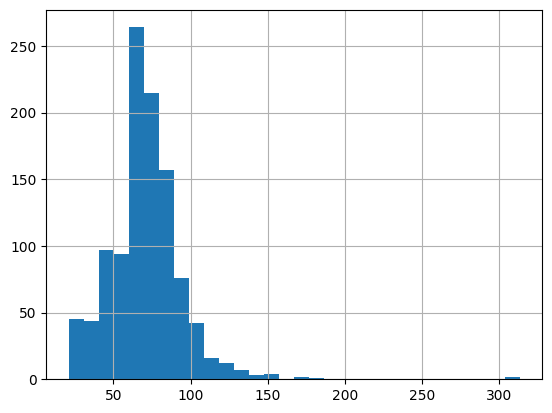

In [54]:
train['LotFrontage'].hist(bins=30);

We could use median imputation for LotFrontage

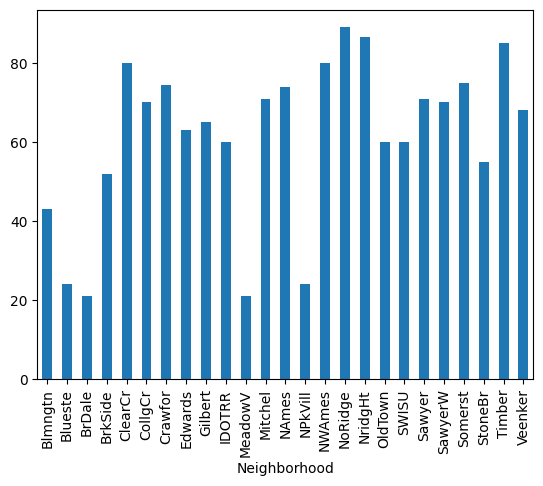

In [55]:
train.groupby('Neighborhood')['LotFrontage'].median().plot(kind='bar');

Or we use neighborhood to help impute missing values in LotFrontage